<font size="20">

# Time- and energy resolved effects in thermal neutrons detectors

<font size="3">

> __Author:__ A. Backis
<br/>__Institute:__ European Spallation Source (ESS), University of Glasgow
<br/>__Date:__ 7/1-2020

_Abstract:_
This notebook contains the data-analysis tools used for the corresponding paper. It describes how the analysis was performed on data obtained with the Multi-Grid detector at the HZB.

## Contents
* [1. Introduction](#INTRODUCTION)
    * [1.1 Overview](#OVERVIEW)
    * [1.2 Packages](#PACKAGES)
* [2. Data](#DATA)
    * [2.1 Extract](#EXTRACT)
    * [2.2 Load](#LOAD)
    * [2.3 Filter](#FILTER)
* [3. Visualization](#VISUALIZATION)
    * [3.1 PHS](#PHS)
        * [3.1.1 1D](#PHS_1D)
        * [3.1.2 2D](#PHS_2D)
        * [2.1.3 Wires vs grids](#PHS_WIRES_VS_GRIDS)
    * [3.2 Time-of-flight](#TIME_OF_FLIGHT)
    * [3.3 Coincidences](#COINCIDENCES)
        * [3.3.1 Wires vs grids](#COINCIDENCES_WIRES_VS_GRIDS)
        * [3.3.2 Projections](#PROJECTIONS)
        * [3.3.3 3D-Rotation](#3D_ROTATION)
    * [3.4 Multiplicity](#MULTIPLICITY)
    * [3.5 Rate](#RATE)
    * [3.6 Layers](#LAYERS)
    * [3.7 Energy](#ENERGY)
    * [3.8 Wavelength](#WAVELENGTH)
* [4. Analysis](#ANALYSIS)
    * [4.1 Electronic noise](#ELECTRONIC_NOISE)
    * [4.2 Efficiency](#EFFICIENCY)
    * [4.3 Line shape](#LINE_SHAPE)
    * [4.4 Time- and energy resolution](#TIME_AND_ENERGY_RESOLUTION)
* [Acknowledgements](#ACKNOWLEDGEMENTS)
* [References](#REFERENCES)

### 1. Introduction<a class="anchor" id="INTRODUCTION"></a>

#### 1.1 Overview<a class="anchor" id="OVERVIEW"></a>

#### 1.2 Packages<a class="anchor" id="PACKAGES"></a>

In [1]:
# Autoload packages when doing an external change
%load_ext autoreload
%autoreload 2

# General packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm

# Data handling
import mg.file_handling.read as mg_read
import he3.read as he3_read

# Plotting
import mg.plotting.basic_plot as mg_basic_plot
import mg.plotting.advanced_plot as mg_advanced_plot
import mg_let.basic_plot as mg_let_plot
import he3.plotting as he3_plot

# Energy calculation
import mg.helper_functions.energy_calculation as mg_energy
import he3.energy_calculation as he3_energy

# Helper functions
import mg.helper_functions.misc as mg_hf
import he3.funct_PileupCorr as he3_pileup

Declare global variables:

In [2]:
# Declare beam monitors norms
MONITOR_NORM_R = 1/11411036
MONITOR_NORM_NR = 1/9020907
MONITOR_NORM_HE3 = 1/10723199

# Declare distance offsets
DIST_OFFSET_R = 1.5e-3
DIST_OFFSET_NR = 0
DIST_OFFSET_HE3 = 3e-3

# Declare peak locations for He-3 tubes
PEAKS = np.array([0.886, 1.030, 1.177, 1.321, 1.466, 1.610, 1.755, 1.900, 2.044, 2.188, 
                  2.333, 2.477, 2.622, 2.766, 2.911, 3.056, 3.200, 3.344, 3.489, 3.633,
                  3.778, 3.923, 4.068, 4.211, 4.356, 4.500, 4.645, 4.790, 4.934, 5.079,
                  5.223, 5.368, 5.513, 5.657, 5.801, 5.946, 6.090, 6.235, 6.379, 6.524,
                  6.669, 6.813, 6.958, 7.102, 7.246, 7.391, 7.536, 7.680, 7.825, 7.969])

In [ ]:
mg_hf.meV_to_A(25)

### 2. Data<a class="anchor" id="DATA"></a>

In [3]:
# Declare paths to raw data
mg_radial_path = '../data/v20/raw/mvmelst_165_191002_111641_Det2_overnight3.zip'
mg_no_radial_path = '../data/v20/raw/mvmelst_135_190930_141618_Det1_overnight2_30x80_14x60.zip'
he3_path = '../data/v20/raw/2019_09_HZB_He3InBeam54304s_overnight.lst'
mg_no_radial_blocked_by_he3_path = '../data/v20/raw/mvmelst_141_191001_120405_He3InBeam_overnight3.zip'
mg_radial_blocked_by_he3_path = '../data/v20/raw/mvmelst_169_191003_075039_Det2_He3InBeam_overnight4.zip'
# Declare paths to clusters
mg_radial_clusters_path = '../data/v20/processed/clusters_mvmelst_165_191002_111641_Det2_overnight3.h5'
mg_no_radial_clusters_path = '../data/v20/processed/clusters_mvmelst_135_190930_141618_Det1_overnight2_30x80_14x60.h5'
mg_no_radial_blocked_by_he3_clusters_path = '../data/v20/processed/clusters_mvmelst_141_191001_120405_He3InBeam_overnight3.zip'
mg_radial_blocked_by_he3_clusters_path = '../data/v20/raw/clusters_mvmelst_169_191003_075039_Det2_He3InBeam_overnight4.zip'
# Declare paths to events
mg_radial_events_path = '../data/v20/processed/events_mvmelst_165_191002_111641_Det2_overnight3.h5'
mg_no_radial_events_path = '../data/v20/processed/events_mvmelst_135_190930_141618_Det1_overnight2_30x80_14x60.h5'
mg_no_radial_blocked_by_he3_events_path = '../data/v20/processed/events_mvmelst_141_191001_120405_He3InBeam_overnight3.zip'
mg_radial_blocked_by_he3_events_path = '../data/v20/raw/events_mvmelst_169_191003_075039_Det2_He3InBeam_overnight4.zip'
he3_events_path = '../data/v20/processed/events_2019_09_HZB_He3InBeam54304s_overnight.h5'

#### 2.1 Extract<a class="anchor" id="EXTRACT"></a>

In [ ]:
def extract_mg_data(zipped_path, clusters_save_path, events_save_path):
    unzipped_path = mg_read.unzip_data(zipped_path)
    data = mg_read.import_data(unzipped_path)
    # Extract clusters and save to disc
    clusters = mg_read.extract_clusters(data)
    mg_read.save_data(clusters, clusters_save_path)
    clusters = None
    # Extract events and save to disc
    events = mg_read.extract_events(data)
    mg_read.save_data(events, events_save_path)
    events = None
    # Clear data
    data = None

In [ ]:
def extract_he3_data(raw_path, save_path):
    df = he3_read.extract_events(raw_path)
    he3_read.save_data(df, save_path)
    df = None

In [ ]:
#extract_mg_data(mg_no_radial_blocked_by_he3_path,
#                mg_no_radial_blocked_by_he3_clusters_path,
#                mg_no_radial_blocked_by_he3_events_path)
#extract_mg_data(mg_radial_path, mg_radial_clusters_path, mg_radial_events_path)
#extract_mg_data(mg_no_radial_path, mg_no_radial_clusters_path, mg_no_radial_events_path)
#extract_he3_data(he3_path, he3_events_path)
extract_mg_data(mg_radial_blocked_by_he3_path,
                mg_radial_blocked_by_he3_clusters_path,
                mg_radial_blocked_by_he3_events_path)

#### 2.2 Load<a class="anchor" id="LOAD"></a>

In [4]:
# Load multi-grid clusters
mg_radial_ce_df = mg_read.load_data(mg_radial_clusters_path)
mg_no_radial_ce_df = mg_read.load_data(mg_no_radial_clusters_path)
mg_no_radial_beam_blocked_ce_df = mg_read.load_data(mg_no_radial_blocked_by_he3_clusters_path)
mg_radial_beam_blocked_ce_df = mg_read.load_data(mg_radial_blocked_by_he3_clusters_path)
# Load multi-grid events
#mg_radial_e_df = mg_read.load_data(mg_radial_events_path)
#mg_no_radial_e_df = mg_read.load_data(mg_no_radial_events_path)
#mg_no_radial_beam_blocked_e_df = mg_read.load_data(mg_no_radial_blocked_by_he3_events_path)
# Load He-3 events
he3_df = he3_read.load_data(he3_events_path)

In [ ]:
duration = (mg_no_radial_beam_blocked_ce_df.time.values[-1] - mg_no_radial_beam_blocked_ce_df.time.values[0]) * 62.5e-9
duration/(60*60)

#### 2.3 Filter<a class="anchor" id="FILTER"></a>

In [5]:
"""
Filters are declared in the following format:
{'PARAMETER': [MIN_VALUE, MAX_VALUE, IS_ACTIVATE]}
"""

us_to_tdc = 1 / (62.5e-9 * 1e6)

# Declare filter for multi-grid clusters
mg_filter_clusters = {'wm': [1, 1, True],                   # Wire multiplicity
                      'gm': [1, 5, True],                   # Grid multiplicity
                      'wadc': [600, np.inf, True],             # Wire charge
                      'gadc': [600, np.inf, True],             # Grid charge
                      'tof': [0, np.inf, True],           # Time-of-flight (TDC channels)
                      'time': [0, np.inf, True],            # Time (TDC channels)
                      'bus': [0, 2, True],                  # Bus
                      'flag': [0, 1, False],                # =1 if different buses within same coincidence
                      'layer': [0, 19, False],              # Layer, front=0 to back=19
                      'row': [0, 11, False],                # Row, right to left (seen from neutrons)
                      'gch': [80, 119, True]}              # Grid channel, bottom=80 to top=119

# Declare filter for multi-grid events
mg_filter_events = {'bus': [0, 2, False],                   # Bus
                    'ch': [0, 119, False],                  # Channel
                    'adc': [0, np.inf, False]}              # Collected charge (ADC channels)

# Declare filters for He-3 data
he3_filter = {'adc': [7500, np.inf, True],                  # Collected charge (ADC channels)
              'tof': [0, 71429e-6, True]}                   # Time-of-flight (s)

# Perform filters
mg_r = mg_read.filter_data(mg_radial_ce_df, mg_filter_clusters)
mg_nr = mg_read.filter_data(mg_no_radial_ce_df, mg_filter_clusters)
mg_nr_blocked = mg_read.filter_data(mg_no_radial_beam_blocked_ce_df, mg_filter_clusters)
mg_r_blocked = mg_read.filter_data(mg_radial_beam_blocked_ce_df, mg_filter_clusters)
he3 = he3_read.filter_data(he3_df, he3_filter)

### 3. Visualization<a class="anchor" id="VISUALIZATION"></a>

#### 3.1 PHS<a class="anchor" id="PHS"></a>

##### 3.1.1 PHS - 1D<a class="anchor" id="PHS_1D"></a>

In [ ]:
%matplotlib notebook
# Define parameters
number_bins = 500
interval = [0, 1e4]
# Plot
fig = plt.figure()
mg_basic_plot.phs_1d_plot(mg_r, number_bins, interval, 'Radial coating')
fig.show()
fig = plt.figure()
mg_basic_plot.phs_1d_plot(mg_nr, number_bins, interval, 'No radial coating')
fig.show()
fig = he3_plot.phs_1d_plot(he3, number_bins, 'He-3')
fig.show()


# Plot - NO FILTERS
fig = plt.figure()
mg_basic_plot.phs_1d_plot(mg_radial_ce_df, number_bins, interval, 'Radial coating')
fig.show()
fig = plt.figure()
mg_basic_plot.phs_1d_plot(mg_no_radial_ce_df, number_bins, interval, 'No radial coating')
fig.show()
fig = he3_plot.phs_1d_plot(he3_df, number_bins, 'He-3')
fig.show()

##### 3.1.2 PHS - 2D<a class="anchor" id="PHS_2D"></a>

In [ ]:
# Define parameters
bus_start = 0
bus_stop = 2
# Plot
fig = mg_basic_plot.phs_2d_plot(mg_radial_e_df, bus_start, bus_stop, 'Radial coating')
fig.show()
fig = mg_basic_plot.phs_2d_plot(mg_no_radial_e_df, bus_start, bus_stop, 'No radial coating')
fig.show()

##### 3.1.3 PHS - Wires vs grids<a class="anchor" id="PHS_WIRES_VS_GRIDS"></a>

In [ ]:
# Define parameters
bus_start = 0
bus_stop = 2
# Plot
fig = mg_basic_plot.phs_wires_vs_grids_plot(mg_r, bus_start, bus_stop, 'Radial coating')
fig.show()
fig = mg_basic_plot.phs_wires_vs_grids_plot(mg_nr, bus_start, bus_stop, 'No radial coating')
fig.show()

#### 3.2 Time-of-flight<a class="anchor" id="TIME_OF_FLIGHT"></a>

In [ ]:
%matplotlib
# Declare parameters
number_bins = 60000
interval = [0, 71429]
# Plot
fig = plt.figure()
mg_basic_plot.tof_histogram(mg_r, number_bins, 'Radial coating', color='green')
fig.show()
fig = plt.figure()
mg_basic_plot.tof_histogram(mg_nr, number_bins, 'No radial coating',
                            label='No radial coating', color='blue')
mg_basic_plot.tof_histogram(mg_nr_blocked, number_bins, 'No radial coating - blocked',
                            label='No radial coating - blocked', color='orange')
plt.legend()
fig.show()
fig = plt.figure()
he3_plot.tof_histogram(he3, number_bins, 'He-3', color='red')
fig.show()
fig = plt.figure()
mg_basic_plot.tof_histogram(mg_r, number_bins, '', label='Radial', interval=interval, color='green')
mg_basic_plot.tof_histogram(mg_nr, number_bins, 'Overlay', label='No radial', interval=interval, color='blue')
he3_plot.tof_histogram(he3, number_bins, label='He-3', interval=interval, color='red')
plt.legend()
fig.show()

fig = plt.figure()
mg_basic_plot.tof_histogram(mg_nr_blocked, 100, '', label='Beam blocked', interval=interval, color='green')
fig.show()

#### 3.3 Coincidences<a class="anchor" id="COINCIDENCES"></a>

##### 3.3.1 Wires vs grids<a class="anchor" id="COINCIDENCES_WIRES_VS_GRIDS"></a>

In [ ]:
# Declare parameters
duration_r = mg_r.time.values[-1] - mg_r.time.values[0]
duration_nr = mg_nr.time.values[-1] - mg_nr.time.values[0]
bus_start = 0
bus_stop = 2
# Plot
fig, __ = mg_basic_plot.ce_2d_plot(mg_r, duration_r, bus_start, bus_stop, 'Radial coating')
fig.show()
fig, __ = mg_basic_plot.ce_2d_plot(mg_nr, duration_nr, bus_start, bus_stop, 'No radial coating')
fig.show()

##### 3.3.2 Projections<a class="anchor" id="PROJECTIONS"></a>

In [ ]:
# Declare parameters
bus_start = 0
bus_stop = 2
# Plot
fig, __ = mg_basic_plot.ce_projections_plot(mg_r, bus_start, bus_stop, 'Radial coating')
fig.show()
fig, __ = mg_basic_plot.ce_projections_plot(mg_nr, bus_start, bus_stop, 'No radial coating')
fig.show()

##### 3.3.3 3D-rotation<a class="anchor" id="3D_ROTATION"></a>

In [ ]:
#mg_basic_plot.ce_3d_plot(mg_r, 'Radial coating')
mg_basic_plot.ce_3d_plot(mg_r_ls_p, 'No radial coating')

#### 3.4 Multiplicity<a class="anchor" id="MULTIPLICITY"></a>

In [ ]:
# Declare parameters
bus_start = 0
bus_stop = 2
# Plot
fig = mg_basic_plot.multiplicity_plot(mg_r, bus_start, bus_stop, 'Radial coating')
fig.show()
fig = mg_basic_plot.multiplicity_plot(mg_nr, bus_start, bus_stop, 'No radial coating')
fig.show()

#### 3.5 Rate<a class="anchor" id="RATE"></a>

In [ ]:
# Declare parameters
number_bins = 50
# Plot
fig = plt.figure()
mg_basic_plot.rate_plot(mg_r, number_bins, 'Radial coating')
mg_basic_plot.rate_plot(mg_nr, number_bins, 'No radial coating')
plt.legend()
fig.show()

##### 3.6 Layers<a class="anchor" id="LAYERS"></a>

###### 3.6.1 Time-of-flight, voxel by voxel

In [ ]:
#fig = mg_advanced_plot.layers_tof(mg_r, 'Multi-Grid:R')
#fig.show()
set_thick_labels(10)
fig = mg_advanced_plot.layers_tof(mg_nr, 'Multi-Grid:NR')
fig.show()

###### 3.6.2 Counts, layer by layer

In [ ]:
# Declare parameters
duration_r = mg_r.time.values[-1] - mg_r.time.values[0]
duration_nr = mg_nr.time.values[-1] - mg_nr.time.values[0]
# Plot
fig = mg_advanced_plot.layers_counts(mg_r, duration_r, 'Coated radial')
fig.show()
fig = mg_advanced_plot.layers_counts(mg_nr, duration_nr, 'Not coated radial')
fig.show()

##### 3.7 Energy<a class="anchor" id="ENERGY"></a>

In [ ]:
%matplotlib notebook

# Calculate energy distribution
energies_r = mg_energy.get_energies(mg_r, DIST_OFFSET_R)
energies_nr = mg_energy.get_energies(mg_nr, DIST_OFFSET_NR)
energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3)

# Declare parameters
number_bins = 10000
start = 0.8 # Å
stop = 10 # Å

# Plot
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
#__, __ = mg_advanced_plot.energy_plot(energies_r, number_bins, 'Radial coating',
#                                      useMaxNorm=True, start=start, stop=stop)
__, __ = mg_advanced_plot.energy_plot(energies_nr, number_bins, 'No radial coating',
                                      useMaxNorm=True, start=start, stop=stop)
__, __ = he3_plot.energy_plot(energies_he3, number_bins, 'Helium-3 tube', 
                              useMaxNorm=True, start=start, stop=stop)
plt.legend()
fig.show()

In [ ]:
mg_hf.A_to_meV(1.5)

##### 3.8 Wavelength<a class="anchor" id="WAVELENGTH"></a>

In [ ]:
%matplotlib
# Calculate energy distribution
energies_r = mg_energy.get_energies(mg_r, DIST_OFFSET_R)
energies_nr = mg_energy.get_energies(mg_nr, DIST_OFFSET_NR)
energies_r_blocked = mg_energy.get_energies(mg_r_blocked, DIST_OFFSET_R)
energies_nr_blocked = mg_energy.get_energies(mg_nr_blocked, DIST_OFFSET_NR)
energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3)

# Declare parameters
number_bins = 50000
start = 0.5
stop = 10

# Plot
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
__, __ = mg_advanced_plot.wavelength_plot(energies_r, number_bins, 'Radial coating',
                                          useMaxNorm=True, start=start, stop=stop)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr, number_bins, 'No radial coating',
                                          useMaxNorm=True, start=start, stop=stop)
__, __ = he3_plot.wavelength_plot(energies_he3, number_bins, 'Helium-3 tube',
                                  useMaxNorm=True, start=start, stop=stop)
plt.legend()
fig.show()
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
__, __ = mg_advanced_plot.wavelength_plot(energies_r, number_bins, 'Radial coating',
                                          useMaxNorm=True, start=start, stop=stop)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr, number_bins, 'No radial coating', 
                                          useMaxNorm=True, start=start, stop=stop)
__, __ = he3_plot.wavelength_plot(energies_he3, number_bins, 'Helium-3 tube',
                                  useMaxNorm=True, start=start, stop=stop)
plt.legend()
plt.yscale('log')
fig.show()

# Plot for paper: Multi-Grid (non-coated) vs Helium-3
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr, number_bins, 'Multi-Grid detector',
                                          useMaxNorm=False, start=start, stop=stop, color='blue')
__, __ = he3_plot.wavelength_plot(energies_he3, number_bins, 'Helium-3 tube',
                                  useMaxNorm=False, start=start, stop=stop, color='red')
plt.legend()
fig.show()

In [ ]:
# Calculate energy distribution
energies_nr = mg_energy.get_energies(mg_nr, DIST_OFFSET_NR)
energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3)

# Declare parameters
number_bins = 50000
start = 0.5
stop = 10

# Plot for paper: Multi-Grid (non-coated) vs Helium-3
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
__, __ = he3_plot.wavelength_plot(energies_he3, number_bins, 'Helium-3 tube',
                                  useMaxNorm=False, start=start, stop=stop, color='red',
                                  scaling=MONITOR_NORM_HE3
                                 )
__, __ = mg_advanced_plot.wavelength_plot(energies_nr, number_bins, 'Multi-Grid detector',
                                          useMaxNorm=False, start=start, stop=stop, color='blue',
                                          scaling=MONITOR_NORM_NR
                                         )
plt.legend()
plt.xlim(0, 7)
fig.show()
output_path = '../output/mg_vs_he3_all_peaks.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
# =============================================================================
#                                 GET ALL PEAKS - WAVELENGTH
# =============================================================================

# Calculate energy distribution
energies_r = mg_energy.get_energies(mg_r, DIST_OFFSET_R)
energies_nr = mg_energy.get_energies(mg_nr, DIST_OFFSET_NR)
energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3)

# Define peak locations (here we use the He-3 peak locations)
peaks = np.array([0.886, 1.030, 1.177, 1.321, 1.466, 1.610, 1.755, 1.900, 2.044, 2.188, 
                  2.333, 2.477, 2.622, 2.766, 2.911, 3.056, 3.200, 3.344, 3.489, 3.633,
                  3.778, 3.923, 4.068, 4.211, 4.356, 4.500, 4.645, 4.790, 4.934, 5.079,
                  5.223, 5.368, 5.513, 5.657, 5.801, 5.946, 6.090, 6.235, 6.379, 6.524,
                  6.669, 6.813, 6.958, 7.102, 7.246, 7.391, 7.536, 7.680, 7.825, 7.969])
peak_window = 0.04

# Declare plotting specifications
number_bins = 250
lower_y = 0
upper_y = 40e3

# Iterate through all peaks
for peak in peaks:
    # Plot all data together
    fig = plt.figure()
    hist_r, bins_r = mg_advanced_plot.wavelength_plot(energies_r, number_bins, 'Multi-Grid:R',
                                                      start=peak-peak_window/2, stop=peak+peak_window/2,
                                                      color='green', scaling=MONITOR_NORM_R)
    hist_nr, bins_nr = mg_advanced_plot.wavelength_plot(energies_nr, number_bins, 'Multi-Grid:NR',
                                                        start=peak-peak_window/2, stop=peak+peak_window/2,
                                                        color='blue', scaling=MONITOR_NORM_NR)
    hist_he3, bins_he3 = he3_plot.wavelength_plot(energies_he3, number_bins, 'Helium-3',
                                                  start=peak-peak_window/2, stop=peak+peak_window/2,
                                                  color='red', scaling=MONITOR_NORM_HE3)
    plt.legend(title='Detector')
    plt.title('Wavelength distribution, peak at %.3f Å (%.3f meV)' % (peak, mg_hf.A_to_meV(peak)))
    plt.ylabel('Normalized counts')
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=5)
    #plt.yscale('log')
    # Save data
    output_path = '../output/peak_at_%.2f_Å_%.2f_meV.pdf' % (peak, mg_hf.A_to_meV(peak))
    fig.savefig(output_path, bbox_inches='tight')
    plt.close()

In [ ]:
# =============================================================================
#                                 GET ALL PEAKS - ENERGY
# =============================================================================


# TEMP
#mg_nr_ls_c = mg_nr_ls[((((mg_nr_ls.bus * 4) + mg_nr_ls.wch//20) == 6) &
#                        (mg_nr_ls.gch >= 87) & (mg_nr_ls.gch <= 89))]
#energies_nr_ls_c = mg_energy.get_energies(mg_nr_ls_c, DIST_OFFSET_NR)

mg_hf.set_thick_labels(9)

# Calculate energy distribution
energies_r = mg_energy.get_energies(mg_r, DIST_OFFSET_R)
energies_nr = mg_energy.get_energies(mg_nr, DIST_OFFSET_NR)
#energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3+20e-3)
energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3)

# Define peak locations (here we use the He-3 peak locations)
peaks = np.array([0.886, 1.030, 1.177, 1.321, 1.466, 1.610, 1.755, 1.900, 2.044, 2.188, 
                  2.333, 2.477, 2.622, 2.766, 2.911, 3.056, 3.200, 3.344, 3.489, 3.633,
                  3.778, 3.923, 4.068, 4.211, 4.356, 4.500, 4.645, 4.790, 4.934, 5.079,
                  5.223, 5.368, 5.513, 5.657, 5.801, 5.946, 6.090, 6.235, 6.379, 6.524,
                  6.669, 6.813, 6.958, 7.102, 7.246, 7.391, 7.536, 7.680, 7.825, 7.969])
peak_window = 0.12#0.06

# Declare plotting specifications
number_bins = 250
lower_y = 0
upper_y = 40e3

# Iterate through all peaks
for peak in peaks:
    # Plot all data together
    fig = plt.figure()
    fig.set_figheight(4)
    fig.set_figwidth(5)
    hist_nr, bins_nr = mg_advanced_plot.energy_plot(energies_nr_ls, number_bins, 'Multi-Grid detector\n(Detector 1)',
                                                start=peak-peak_window/2, stop=peak+peak_window/2,
                                                color='blue', scaling=MONITOR_NORM_NR)
    hist_r, bins_r = mg_advanced_plot.energy_plot(energies_r_ls, number_bins, 'Multi-Grid detector\n(Detector 2)',
                                                  start=peak-peak_window/2, stop=peak+peak_window/2,
                                                  color='green', scaling=MONITOR_NORM_R)
    hist_he3, bins_he3 = he3_plot.energy_plot(energies_he3, number_bins, 'Helium-3 tube',
                                              start=peak-peak_window/2, stop=peak+peak_window/2,
                                              color='red', scaling=MONITOR_NORM_HE3)
    
    #hist_nr, bins_nr = mg_advanced_plot.energy_plot(energies_nr_ls, number_bins, 'Multi-Grid detector\n(full data)',
    #                                            start=peak-peak_window/2, stop=peak+peak_window/2,
    #                                            color='blue', useMaxNorm=True, linestyle='solid') 
    
    #mg_advanced_plot.energy_plot(energies_nr_ls_p, number_bins, 'Multi-Grid detector\n(beam periphery)',
    #                                            start=peak-peak_window/2, stop=peak+peak_window/2,
    #                                            color='red', scaling=2.72116248e-05, linestyle='dashed') 
    
    #mg_advanced_plot.energy_plot(energies_nr_ls_c, number_bins, 'Multi-Grid detector\n(beam center)',
    #                             start=peak-peak_window/2, stop=peak+peak_window/2,
    #                             color='green', scaling=2.72116248e-05, linestyle='dotted') 

    #hist_he3, bins_he3 = he3_plot.energy_plot(energies_he3, number_bins, 'Helium-3 tube',
    #                                          start=peak-peak_window/2, stop=peak+peak_window/2,
    #                                          color='orange', useMaxNorm=True, linestyle='dashdot')
    
    plt.legend(title='Detector')
    plt.legend()
    plt.title('Energy distribution, peak at %.2f Å' % peak)
    #plt.title('Peak @ %.2f Å' % peak)
    #plt.ylabel('Counts normalized to maximum')
    plt.ylabel('Normalized counts')
    plt.yscale('log')
    plt.xscale('linear')
    plt.xlim(mg_hf.A_to_meV(peak+peak_window/2), mg_hf.A_to_meV(peak-peak_window/2))
    plt.locator_params(axis='x', nbins=5)
    #plt.yscale('linear')
    # Save data
    output_path = '../output/peak_at_%d_A.pdf' % ((peak*100)//1)
    fig.savefig(output_path, bbox_inches='tight')
    plt.close()

##### 3.9 Event distribution

In [ ]:
# Declare parameters
number_bins = 20000
interval = [-0.05, 0.05]

# Plot Helium-3 vs Multi-Grid distribution between events
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.hist(np.diff(he3.tof.values), bins=number_bins, range=interval,
         zorder=5, label='Helium-3', histtype='step')
plt.hist(np.diff(mg_r.tof.values * 62.5e-9), bins=number_bins, range=interval,
         zorder=5, label='Multi-Grid:R', histtype='step')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.xlabel('Delta_t (s)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Helium-3 vs Multi-Grid:R')
plt.legend()
fig.show()

# Plot zoomed
interval = [0, 0.0002]
number_bins = 1000
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.hist(np.diff(he3.tof.values), bins=number_bins, range=interval,
         zorder=5, label='Helium-3', histtype='step')
plt.hist(np.diff(mg_r.tof.values * 62.5e-9), bins=number_bins, range=interval,
         zorder=5, label='Multi-Grid:R', histtype='step')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.xlabel('Delta_t (s)')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Helium-3 vs Multi-Grid:R')
plt.legend()
fig.show()

##### 3.10 Helium-3 pile up distribution

In [ ]:
# Calculate Helium-3 pile up
all_he3 = mg_hf.meV_to_A(he3_energy.get_energies(he3, DIST_OFFSET_HE3))
pileup_he3 = mg_hf.meV_to_A(he3_energy.get_energies(he3[he3.pile_up == 1], DIST_OFFSET_HE3))
hist_all, bin_edges = np.histogram(all_he3, bins=1000, range=[0, 7])
hist_pileup, __ = np.histogram(pileup_he3, bins=1000, range=[0, 7])
he3_bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
pileup_fraction = hist_pileup/hist_all

##### 3.11 Beam monitor distribution and He-3 plot for paper

In [ ]:
def tof_and_d_to_angstrom(tof, d):
    return 3956 * (tof/d)
    

bm_path_pa = '../data/v20/bm/overnight2.bn4ch1_bin400.asc'
bm_path_he3 = '../data/v20/bm/He3_overnight_Fermi_Chopper_measurement.bn4ch1_bin400.asc'
bm_path_rc_blocked = '../data/v20/bm/He_3_tube_Fermi_Measurement_overnight2_thursday.bn4ch1_bin400.asc'
d_bm = 25.48

# Import data
bm_data_pa = np.transpose(np.loadtxt(bm_path_pa, delimiter="\t"))
tof_pa = (bm_data_pa[0] * 1000) * 1e-6 + (0.6e-3)
wavelength_pa = tof_and_d_to_angstrom(tof_pa, d_bm)
y_pa = bm_data_pa[1]

bm_data_he3 = np.transpose(np.loadtxt(bm_path_he3, delimiter="\t"))
tof_he3 = (bm_data_he3[0] * 1000) * 1e-6 + (0.6e-3)
wavelength_he3 = tof_and_d_to_angstrom(tof_he3, d_bm)
y_he3 = bm_data_he3[1]

bm_data_rc_blocked = np.transpose(np.loadtxt(bm_path_rc_blocked, delimiter="\t"))
tof_rc_blocked = (bm_data_he3[0] * 1000) * 1e-6 + (0.6e-3)
wavelength_rc_blocked = tof_and_d_to_angstrom(tof_rc_blocked, d_bm)
y_rc_blocked = bm_data_rc_blocked[1]
print(sum(y_rc_blocked))

# Plot bm data
mg_hf.set_thick_labels(15)
fig = plt.figure()
#fig.set_figheight(4)
#fig.set_figwidth(5)
# First subplot
plt.step(wavelength_pa, y_pa/46513, zorder=5, color='blue', label='BM, Multi-Grid run ($BM_{MG}$)')
plt.step(wavelength_he3, y_he3/54304, zorder=5, color='red', label='BM, Helium-3 run ($BM_{He-3}$)',
         linestyle='--')
#plt.step(wavelength_rc_blocked, y_rc_blocked, label='BM, CRB blocked', color='black',zorder=10)

# Stylize plot
plt.title('Beam monitor rate')
plt.xlim(1, 7)
plt.legend()
#plt.yscale('log')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Count rate (s$^{-1}$)')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
#plt.ticklabel_format(style='sci')
#plt.locator_params(axis='x', nbins=5)
#plt.locator_params(axis='y', nbins=5)
fig.show()

# Save data
output_path = '../output/bm_counts_comparison.pdf'
fig.savefig(output_path, bbox_inches='tight')


# Second subplot
fig = plt.figure()
#fig.set_figheight(4)
#fig.set_figwidth(5)
errors = np.sqrt((np.sqrt(y_pa)/y_pa) ** 2 + (np.sqrt(y_he3)/y_he3) ** 2) * (54304/46513)
plt.errorbar(wavelength_pa, (y_pa/46513)/(y_he3/54304), errors, zorder=5, color='black', marker='.',
             linestyle='', label='$BM_{MG}$/$BM_{He-3}$')

# Stylize plot
plt.legend()
plt.title('Fractional beam monitor rate')
plt.xlim(1, 7)
plt.ylim(0.9, 1.1)
#plt.ylim(0.5, 1.2)
#plt.ylim(0.7, 0.8)
plt.xlabel('Wavelength (Å)')
plt.ylabel('$BM_{MG}$/$BM_{He-3}$')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)

fig.show()

# Save data
output_path = '../output/bm_fractional_comparison.pdf'
fig.savefig(output_path, bbox_inches='tight')


In [ ]:
mg_hf.get_duration(mg_nr)
print(46513/54304)

In [ ]:
# Import data
bm_path_crb = '../data/v20/bm/Coated_radial_Blades_overnight_measurement_Fermi_Chopper.bn4ch1_bin400.asc'
bm_data = np.transpose(np.loadtxt(bm_path_crb, delimiter="\t"))
x = bm_data[0] * 1000
y = bm_data[1]
norm = 1/max(y)

# Plot bm data
mg_hf.set_thick_labels(15)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(6)
plt.step(x, y, zorder=5, color='black')
#plt.title('ToF - Beam Monitor')
plt.xlabel('tof (µs)')
plt.ylabel('Counts')
#plt.yscale('log')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.ticklabel_format(style='sci')
fig.show()
# Save data
output_path = '../output/bmtof.pdf'
fig.savefig(output_path, bbox_inches='tight')

# Plot He-3 data
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(6)
plt.ticklabel_format(style='sci')
number_bins = 30000
he3_plot.tof_histogram(he3, number_bins, label='', color='black')
plt.ticklabel_format(style='sci', axis='x')
#plt.locator_params(axis='x', nbins=5)
#plt.locator_params(axis='y', nbins=5)
plt.title('')
plt.xlabel('tof ($\mu$s)')
fig.show()
# Save data
output_path = '../output/he3tof.pdf'
fig.savefig(output_path, bbox_inches='tight')


# Plot He-3 data - zoom
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
number_bins = 30000
he3_plot.tof_histogram(he3, number_bins, label='', color='black')
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.xlim(33.5e3, 37.5e3)
plt.yscale('log')
plt.ylim(6, 5e4)
plt.title('')
plt.xlabel('tof ($\mu$s)')
fig.show()
# Save data
output_path = '../output/he3tofzoom.pdf'
fig.savefig(output_path, bbox_inches='tight')

### 4. Analysis<a class="anchor" id="ANALYSIS"></a>

##### 4.1 Electronic noise<a class="anchor" id="ELECTRONIC_NOISE"></a>

In [ ]:
# Perform filter, with no adc cuts
us_to_tdc = 1 / (62.5e-9 * 1e6)

bus_start = 0
bus_stop = 2

# Declare filter for multi-grid clusters
mg_filter_clusters = {'wm': [1, 1, False],                   # Wire multiplicity
                      'gm': [1, 5, False],                   # Grid multiplicity
                      'wadc': [0, np.inf, True],               # Wire charge
                      'gadc': [0, np.inf, True],               # Grid charge
                      'tof': [0, np.inf, True],             # Time-of-flight (TDC channels)
                      'time': [0, np.inf, True],            # Time (TDC channels)
                      'bus': [bus_start, bus_stop, True],                  # Bus
                      'flag': [0, 1, False],                # =1 if different buses within same coincidence
                      'layer': [0, 19, False],              # Layer, front=0 to back=19
                      'row': [0, 11, True],                # Row, right to left (seen from neutrons)
                      'gch': [80, 119, True]}               # Grid channel, bottom=80 to top=119

# Declare filter for multi-grid clusters
mg_filter_clusters_low_adc = {'wm': [1, 1, True],                   # Wire multiplicity
                              'gm': [1, 5, True],                   # Grid multiplicity
                              'wadc': [0, 1500, True],               # Wire charge
                              'gadc': [0, 1500, True],               # Grid charge
                              'tof': [0, np.inf, True],             # Time-of-flight (TDC channels)
                              'time': [0, np.inf, True],            # Time (TDC channels)
                              'bus': [bus_start, bus_stop, True],                  # Bus
                              'flag': [0, 1, False],                # =1 if different buses within same coincidence
                              'layer': [0, 19, False],              # Layer, front=0 to back=19
                              'row': [0, 11, True],                # Row, right to left (seen from neutrons)
                              'gch': [80, 119, True]}               # Grid channel, bottom=80 to top=119

# Declare filter for multi-grid clusters
mg_filter_clusters_high_adc = {'wm': [1, 1, True],                   # Wire multiplicity
                               'gm': [1, 5, True],                   # Grid multiplicity
                               'wadc': [1200, np.inf, True],               # Wire charge
                               'gadc': [1200, np.inf, True],               # Grid charge
                               'tof': [0, np.inf, True],             # Time-of-flight (TDC channels)
                               'time': [0, np.inf, True],            # Time (TDC channels)
                               'bus': [bus_start, bus_stop, True],                  # Bus
                               'flag': [0, 1, False],                # =1 if different buses within same coincidence
                               'layer': [0, 19, False],              # Layer, front=0 to back=19
                               'row': [0, 11, True],                # Row, right to left (seen from neutrons)
                               'gch': [80, 119, True]}               # Grid channel, bottom=80 to top=119

# Declare filter front for multi-grid clusters
mg_filter_clusters_front = {'wm': [1, 1, True],                   # Wire multiplicity
                               'gm': [1, 5, True],                   # Grid multiplicity
                               'wadc': [0, np.inf, True],               # Wire charge
                               'gadc': [0, np.inf, True],               # Grid charge
                               'tof': [0, np.inf, True],             # Time-of-flight (TDC channels)
                               'time': [0, np.inf, True],            # Time (TDC channels)
                               'bus': [bus_start, bus_stop, True],                  # Bus
                               'flag': [0, 1, False],                # =1 if different buses within same coincidence
                               'layer': [0, 9, True],              # Layer, front=0 to back=19
                               'row': [0, 11, True],                # Row, right to left (seen from neutrons)
                               'gch': [80, 119, True]}               # Grid channel, bottom=80 to top=119

# Declare filter back for multi-grid clusters
mg_filter_clusters_back = {'wm': [1, 1, True],                   # Wire multiplicity
                               'gm': [1, 5, True],                   # Grid multiplicity
                               'wadc': [0, np.inf, True],               # Wire charge
                               'gadc': [0, np.inf, True],               # Grid charge
                               'tof': [0, np.inf, True],             # Time-of-flight (TDC channels)
                               'time': [0, np.inf, True],            # Time (TDC channels)
                               'bus': [bus_start, bus_stop, True],                  # Bus
                               'flag': [0, 1, False],                # =1 if different buses within same coincidence
                               'layer': [10, 19, True],              # Layer, front=0 to back=19
                               'row': [0, 11, True],                # Row, right to left (seen from neutrons)
                               'gch': [80, 119, True]}               # Grid channel, bottom=80 to top=119

# Declare filter back for multi-grid clusters
mg_filter_clusters_high_wm = {'wm': [1, np.inf, True],                   # Wire multiplicity
                               'gm': [1, 1, True],                   # Grid multiplicity
                               'wadc': [0, np.inf, True],               # Wire charge
                               'gadc': [0, np.inf, True],               # Grid charge
                               'tof': [0, np.inf, True],             # Time-of-flight (TDC channels)
                               'time': [0, np.inf, True],            # Time (TDC channels)
                               'bus': [bus_start, bus_stop, True],                  # Bus
                               'flag': [0, 1, False],                # =1 if different buses within same coincidence
                               'layer': [10, 19, True],              # Layer, front=0 to back=19
                               'row': [0, 11, True],                # Row, right to left (seen from neutrons)
                               'gch': [80, 119, True]}

# Declare filter back for multi-grid clusters
mg_filter_clusters_no_m_filter = {'wm': [0, np.inf, True],                   # Wire multiplicity
                                  'gm': [0, np.inf, True],                   # Grid multiplicity
                                  'wadc': [600, np.inf, True],               # Wire charge
                                  'gadc': [600, np.inf, True],               # Grid charge
                                  'tof': [0, np.inf, True],             # Time-of-flight (TDC channels)
                                  'time': [0, np.inf, True],            # Time (TDC channels)
                                  'bus': [bus_start, bus_stop, True],                  # Bus
                                  'flag': [0, 1, False],                # =1 if different buses within same coincidence
                                  'layer': [10, 19, True],              # Layer, front=0 to back=19
                                  'row': [0, 11, True],                # Row, right to left (seen from neutrons)
                                  'gch': [80, 119, True]}



# Perform filters
mg_nr_noise = mg_read.filter_data(mg_no_radial_ce_df, mg_filter_clusters)

mg_nr_low_adc = mg_read.filter_data(mg_no_radial_ce_df, mg_filter_clusters_low_adc)
mg_nr_high_adc = mg_read.filter_data(mg_no_radial_ce_df, mg_filter_clusters_high_adc)
mg_r_high_adc = mg_read.filter_data(mg_radial_ce_df, mg_filter_clusters_high_adc)

#mg_nr_front = mg_read.filter_data(mg_no_radial_ce_df, mg_filter_clusters_front)
#mg_nr_back = mg_read.filter_data(mg_no_radial_ce_df, mg_filter_clusters_back)

#mg_nr_high_wm = mg_read.filter_data(mg_no_radial_ce_df, mg_filter_clusters_high_wm)

# Cut a piece in middle and another at the beam
#mg_middle = mg_nr_noise[(mg_nr_noise.gch >= 98) & (mg_nr_noise.gch <= 101)]
#mg_beam = mg_nr_noise[(mg_nr_noise.gch >= 80) & (mg_nr_noise.gch <= 90)]
#mg_top = mg_nr_noise[(mg_nr_noise.gch >= 102)]

# Cut a piece in middle and another at the beam
#mg_middle_high_adc = mg_nr_high_adc[(mg_nr_high_adc.gch >= 98) & (mg_nr_high_adc.gch <= 101)]
#mg_beam_high_adc = mg_nr_high_adc[(mg_nr_high_adc.gch >= 80) & (mg_nr_high_adc.gch <= 90)]
#mg_top_high_adc = mg_nr_high_adc[(mg_nr_high_adc.gch >= 102)]

# Cut a piece in middle and another at the beam
#mg_middle_low_adc = mg_nr_low_adc[(mg_nr_low_adc.gch >= 98) & (mg_nr_low_adc.gch <= 101)]
#mg_beam_low_adc = mg_nr_low_adc[(mg_nr_low_adc.gch >= 80) & (mg_nr_low_adc.gch <= 90)]
#mg_top_low_adc = mg_nr_low_adc[(mg_nr_low_adc.gch >= 102)]

mg_nr_no_m_filter = mg_read.filter_data(mg_no_radial_ce_df, mg_filter_clusters_no_m_filter)
mg_nr_blocked_high_adc = mg_read.filter_data(mg_no_radial_beam_blocked_ce_df, mg_filter_clusters_high_adc)

In [ ]:
# Declare parameters
mg_hf.set_thick_labels(15)
bus_start = 0
bus_stop = 2
# Plot
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(10)
mg_basic_plot.ce_projections_plot(mg_nr_noise, bus_start, bus_stop, '')
fig.show()
# Save data
output_path = '../output/projections_noise.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
fig = plt.figure()
plt.hist2d(mg_nr_high_wm.gch, mg_nr_high_wm.wm, norm=LogNorm(), bins=[40, 10])
plt.colorbar()
fig.show()

fig = plt.figure()
for channel in np.arange(90, 110, 1):
    plt.hist(mg_nr_high_wm[mg_nr_high_wm.gch == channel].wm, bins=10, range=[0, 10],
             label=channel, histtype='step')
plt.yscale('log')
plt.legend()
fig.show()

In [ ]:
# Declare parameters
duration = mg_beam.time.values[-1] - mg_beam.time.values[0]
bus_start = 0
bus_stop = 2
# Plot
fig, __ = mg_basic_plot.ce_2d_plot(mg_middle, duration, bus_start, bus_stop, 'Middle')
fig.show()
fig, __ = mg_basic_plot.ce_2d_plot(mg_beam, duration, bus_start, bus_stop, 'Beam')
fig.show()

In [ ]:
%matplotlib notebook
# Define parameters
number_bins = 5000
interval = [0, 1e4]
# Plot
fig = plt.figure()
mg_basic_plot.phs_1d_plot(mg_beam, number_bins, interval, 'Beam')
mg_basic_plot.phs_1d_plot(mg_middle, number_bins, interval, 'Middle')
plt.yscale('log')
fig.show()

In [ ]:
%matplotlib inline
# Plot multiplicity
mg_hf.set_thick_labels(15)
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)

# Declare parameters
m_range = [0, 10, 0, 10]
# Plot data
hist, xbins, ybins, im = plt.hist2d(mg_nr_no_m_filter.wm,
                                    mg_nr_no_m_filter.gm,
                                    bins=[m_range[1]-m_range[0]+1,
                                          m_range[3]-m_range[2]+1],
                                    range=[[m_range[0], m_range[1]+1],
                                           [m_range[2], m_range[3]+1]],
                                    norm=LogNorm(),
                                    #vmin=vmin, vmax=vmax,
                                    cmap='jet')
# Iterate through all squares and write percentages
tot = mg_nr_no_m_filter.shape[0]
font_size = 8
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        if hist[j, i] > 0:
            text = plt.text(xbins[j]+0.5, ybins[i]+0.5,
                            '%.d%%' % (100*(hist[j, i]/tot)),
                            color="w", ha="center", va="center",
                            fontweight="bold", fontsize=font_size)
            text.set_path_effects([path_effects.Stroke(linewidth=1,
                                                       foreground='black'),
                                   path_effects.Normal()])
# Set ticks on axis
ticks_x = np.arange(m_range[0], m_range[1]+1, 1)
locs_x = np.arange(m_range[0] + 0.5, m_range[1]+1.5, 1)
ticks_y = np.arange(m_range[2], m_range[3]+1, 1)
locs_y = np.arange(m_range[2] + 0.5, m_range[3]+1.5, 1)
plt.xticks(locs_x, ticks_x)
plt.yticks(locs_y, ticks_y)
plt.xlabel("Wire multiplicity")
plt.ylabel("Grid multiplicity")
cbar = plt.colorbar()
cbar.set_label('Counts')
plt.tight_layout()
fig.show()

# Save data
output_path = '../output/multi_dist.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
%matplotlib inline
mg_hf.set_thick_labels(15)
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d(mg_nr_noise.gadc, mg_nr_noise.gch, norm=LogNorm(), cmap='jet', bins=[100, 40],
           range=[[0, 4095], [79.5, 119.5]],
           vmin=3e1, vmax=1e5,
          )
cbar = plt.colorbar()
cbar.set_label('Counts')
plt.xlabel('Collected charge (adc channels)')
plt.ylabel('Grid')
fig.show()
# Save data
output_path = '../output/gch_vs_adc.pdf'
fig.savefig(output_path, bbox_inches='tight')

#fig = plt.figure()
#peak_centers = []
#peak_maxs = []
#channels = np.arange(80, 120, 1)
#for channel in channels:
#    hist, bin_edges, *_ = plt.hist(mg_nr_noise[mg_nr_noise.gch == channel].gadc,
#                                   bins=1000, range=[0, 7000], histtype='step', label=channel)
#    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
#    hist_temp = hist[bin_centers <= 800]
#    max_idx = mg_hf.find_nearest(hist_temp, max(hist_temp))
#    peak_centers.append(bin_centers[max_idx])
#    peak_maxs.append(hist_temp[max_idx])
#plt.legend()
#fig.show()

#fig = plt.figure()
#plt.plot(channels, peak_centers, '.-', color='black')
#fig.show()

#fig = plt.figure()
#plt.plot(channels, peak_maxs, '.-', color='black')
#fig.show()

In [ ]:
mg_hf.set_thick_labels(15)
# Declare parameters
time_offset = (0.6e-3) * 1e6
period_time = (1/14) * 1e6

# Plot
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(14)
plt.hist2d((mg_nr_noise.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           mg_nr_noise.gch,
           bins=[500, 40],
           #range=[[0, 7e4], [0.5, 39.5]],
           #vmin=5e2, vmax=5e3,
           norm=LogNorm(),
           cmap='jet')
plt.xlabel('tof (µs)')
plt.ylabel('Grid')
cbar = plt.colorbar()
cbar.set_label('Counts')
fig.show()
# Save data
output_path = '../output/grid_vs_tof.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
mg_hf.set_thick_labels(15)

# Declare parameters
time_offset = (0.6e-3) * 1e6
period_time = (1/14) * 1e6

# Plot
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_nr_blocked.bus * 4) + mg_nr_blocked.wch//20,
           (mg_nr_blocked.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           bins=[12, 300],
           #range=[[0, 7e4], [0.5, 39.5]],
           #vmin=100, vmax=6e5,
           norm=LogNorm(),
           #weights=np.ones(mg_r_high_adc.shape[0])*MONITOR_NORM_R,
           cmap='jet')
plt.xlabel('Row')
#plt.xticks(np.arange(0, 10, 1)+0.5, np.arange(0, 10, 1))
plt.ylabel('tof (µs)')
cbar = plt.colorbar()
cbar.set_label('Counts')
plt.ticklabel_format(style='sci', axis='y')
fig.show()
# Save data
output_path = '../output/row_vs_tof_non_coated.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
mg_hf.set_thick_labels(15)

# Declare parameters
time_offset = (0.6e-3) * 1e6
period_time = (1/14) * 1e6

# Plot
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_nr_high_adc.bus * 4) + mg_nr_high_adc.wch//20,
           (mg_nr_high_adc.wch % 20),
           bins=[12, 20],
           #range=[[0, 7e4], [0.5, 39.5]],
           #vmin=100, vmax=6e5,
           norm=LogNorm(),
           #weights=np.ones(mg_r_high_adc.shape[0])*MONITOR_NORM_R,
           cmap='jet')
plt.xlabel('Row')
plt.ylabel('Layer')
cbar = plt.colorbar()
cbar.set_label('Counts')
fig.show()
# Save data
output_path = '../output/row_vs_layer_non_coated.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
# Compare coated and non-coated radial blades

MONITOR_NORM_R = 1/11411036
MONITOR_NORM_NR = 1/9020907
MONITOR_NORM_HE3 = 1/10723199

mg_hf.set_thick_labels(15)
# Declare parameters
time_offset = (0.6e-3) * 1e6
period_time = (1/14) * 1e6

# Plot non-coated radial
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_nr_high_adc.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           mg_nr_high_adc.gch,
           bins=[500, 40],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=1e-5, vmax=1e-3,
           norm=LogNorm(),
           weights=np.ones(mg_nr_high_adc.shape[0])*MONITOR_NORM_NR,
           cmap='jet')
plt.xlabel('tof (µs)')
plt.ylabel('Grid')
cbar = plt.colorbar()
cbar.set_label('Counts')
fig.show()
# Save data
output_path = '../output/grid_vs_tof_non_coated.pdf'
fig.savefig(output_path, bbox_inches='tight')

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_nr_high_adc.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           (mg_nr_high_adc.bus * 4) + mg_nr_high_adc.wch//20,
           bins=[500, 12],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=1e-5, vmax=1e-3,
           norm=LogNorm(),
           weights=np.ones(mg_nr_high_adc.shape[0])*MONITOR_NORM_NR,
           cmap='jet')
plt.xlabel('tof (µs)')
plt.ylabel('Row')
cbar = plt.colorbar()
cbar.set_label('Counts')
fig.show()
# Save data
output_path = '../output/row_vs_tof_non_coated.pdf'
fig.savefig(output_path, bbox_inches='tight')

# Plot coated radial
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_r_high_adc.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           mg_r_high_adc.gch,
           bins=[500, 40],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=1e-5, vmax=1e-3,
           norm=LogNorm(),
           weights=np.ones(mg_r_high_adc.shape[0])*MONITOR_NORM_R,
           cmap='jet')
plt.xlabel('tof (µs)')
plt.ylabel('Grid')
cbar = plt.colorbar()
cbar.set_label('Counts')
fig.show()
# Save data
output_path = '../output/grid_vs_tof_non_coated.pdf'
fig.savefig(output_path, bbox_inches='tight')

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_r_high_adc.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           (mg_r_high_adc.bus * 4) + mg_r_high_adc.wch//20,
           bins=[500, 12],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=1e-5, vmax=1e-3,
           norm=LogNorm(),
           weights=np.ones(mg_r_high_adc.shape[0])*MONITOR_NORM_R,
           cmap='jet')
plt.xlabel('tof (µs)')
plt.ylabel('Row')
cbar = plt.colorbar()
cbar.set_label('Counts')
fig.show()
# Save data
output_path = '../output/row_vs_tof_non_coated.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
mg_hf.set_thick_labels(15)
# Declare parameters
time_offset = (0.6e-3) * 1e6
period_time = (1/14) * 1e6

# Plot
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5) # 14
plt.hist2d((mg_nr_noise.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           mg_nr_noise.gch,
           bins=[500, 40],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=3e1, vmax=1e5,
           norm=LogNorm(),
           cmap='jet')
plt.xlabel('tof (µs)')
plt.ylabel('Grid')
cbar = plt.colorbar()
cbar.set_label('Counts')
fig.show()
# Save data
output_path = '../output/grid_vs_tof_low_adc.pdf'
fig.savefig(output_path, bbox_inches='tight')

# Plot
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_nr_blocked.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           mg_nr_blocked.gch,
           bins=[500, 40],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=3e1, vmax=1e5,
           norm=LogNorm(),
           cmap='jet')
plt.xlabel('tof (µs)')
plt.ylabel('Grid')
cbar = plt.colorbar()
cbar.set_label('Counts')
fig.show()
# Save data
output_path = '../output/grid_vs_tof_high_adc.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
fig = plt.figure()
plt.hist2d(mg_nr_front.gadc, mg_nr_front.gch, norm=LogNorm(), cmap='jet', bins=[100, 40],
           range=[[0, 10000], [79.5, 119.5]])
fig.show()

fig = plt.figure()
plt.hist2d(mg_nr_back.gadc, mg_nr_back.gch, norm=LogNorm(), cmap='jet', bins=[100, 40],
           range=[[0, 10000], [79.5, 119.5]])
fig.show()

In [ ]:
# Define parameters
bus_start = 0
bus_stop = 2
# Plot
fig = mg_basic_plot.phs_wires_vs_grids_plot(mg_middle, bus_start, bus_stop, 'Middle')
fig.show()
fig = mg_basic_plot.phs_wires_vs_grids_plot(mg_beam, bus_start, bus_stop, 'Beam')
fig.show()

In [ ]:
%matplotlib notebook
# Declare parameters
number_bins = 300
interval = [0, 71429]
# Plot
fig = plt.figure()
mg_basic_plot.tof_histogram(mg_beam, number_bins, '', label='Beam', color=None)
mg_basic_plot.tof_histogram(mg_middle, number_bins, '',
                            label='Middle', color=None)
mg_basic_plot.tof_histogram(mg_top, number_bins, '',
                            label='Top', color=None)
plt.yscale('log')
plt.legend()
fig.show()

# Plot
fig = plt.figure()
mg_basic_plot.tof_histogram(mg_beam_low_adc, number_bins, '', label='Beam (low adc)', color=None)
mg_basic_plot.tof_histogram(mg_middle_low_adc, number_bins, '',
                            label='Middle (low adc)', color=None)
mg_basic_plot.tof_histogram(mg_top_low_adc, number_bins, '',
                            label='Top (low adc)', color=None)
plt.yscale('log')
plt.legend()
fig.show()

# Plot
fig = plt.figure()
mg_basic_plot.tof_histogram(mg_beam_high_adc, number_bins, '', label='Beam (high adc)', color=None)
mg_basic_plot.tof_histogram(mg_middle_high_adc, number_bins, '',
                            label='Middle (high adc)', color=None)
mg_basic_plot.tof_histogram(mg_top_high_adc, number_bins, '',
                            label='Top (high adc)', color=None)
plt.yscale('log')
plt.legend()
fig.show()

In [ ]:
# Define parameters
bus_number = 2
event_number = 50000

# Extract events
events = mg_no_radial_e_df[(mg_no_radial_e_df.bus == bus_number) &
                           (mg_no_radial_e_df.ch >= 80) &
                           (mg_no_radial_e_df.ch <= 119)]
times = events.time.values
channels = events.ch.values
channel_prev = 0
time_prev = 0
print(events)

# Declare vectors to save data
tdiff_top_to_mid = (-1) * np.ones([len(channels)], dtype=int)
tdiff_bottom_to_mid = (-1) * np.ones([len(channels)], dtype=int)
tdiff_mid_to_mid = (-1) * np.ones([len(channels)], dtype=int)

# Declare counters
count_top_to_mid = 0
count_bottom_to_mid = 0
count_mid_to_mid = 0

top_range = np.arange(105, 120, 1)
middle_range = np.arange(95, 105, 1)
bottom_range = np.arange(80, 95, 1)

# Iterate through data
for i, (time, channel) in enumerate(zip(times, channels)):
    if channel in middle_range:
        if channel_prev in top_range:
            tdiff_top_to_mid[count_top_to_mid] = time - time_prev
            count_top_to_mid += 1
        elif channel_prev in bottom_range:
            tdiff_bottom_to_mid[count_bottom_to_mid] = time - time_prev
            count_bottom_to_mid += 1
        elif channel_prev in middle_range:
            tdiff_mid_to_mid[count_mid_to_mid] = time - time_prev
            count_mid_to_mid += 1
    channel_prev = channel
    time_prev = time
    if i % 100000 == 1:
        print('%d/%d' % (i, len(channels)))

# Iterate through data
#matrix = np.zeros([120, 120], dtype=int)
#for i, (time, channel) in enumerate(zip(times, channels)):
#    matrix[channel, channel_prev] += 1
#    channel_prev = channel
#    time_prev = time
#fig = plt.figure()    
#plt.imshow(matrix, cmap='jet', norm=LogNorm(), origin='lower',
#           interpolation='nearest', aspect='auto')
#plt.colorbar()
#plt.xlim(80, 119)
#plt.ylim(80, 119)
#fig.show()

scale_factor = 62.5e-9 * 1e6
tdiff_top_to_mid = tdiff_top_to_mid[0:count_top_to_mid] * scale_factor
tdiff_bottom_to_mid = tdiff_bottom_to_mid[0:count_bottom_to_mid] * scale_factor
tdiff_mid_to_mid = tdiff_mid_to_mid[0:count_mid_to_mid] * scale_factor

#fig = plt.figure()
#plt.hist(channels, bins=40)
#fig.show()

fig = plt.figure()
number_bins = 1000
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.hist(tdiff_top_to_mid, color='blue', label='Top to mid',
         histtype='step', range=[0, 160000], bins=number_bins,
         zorder=5)
plt.hist(tdiff_bottom_to_mid, color='red', label='Bottom to mid',
         histtype='step', range=[0, 160000], bins=number_bins,
         zorder=5)
plt.hist(tdiff_mid_to_mid, color='green', label='Mid to mid',
         histtype='step', range=[0, 160000], bins=number_bins,
         zorder=5)

plt.legend()
#plt.yscale('log')
fig.show()

# Cut different regions
#cb_middle = mg_no_radial_e_df[(mg_no_radial_e_df.bus == bus_number) &
#                              (mg_no_radial_e_df.ch == 99)
#                              ]#.head(event_number)
#cb_top = mg_no_radial_e_df[(mg_no_radial_e_df.bus == bus_number) &
#                           (mg_no_radial_e_df.ch >= 100) &
#                           (mg_no_radial_e_df.ch <= 119)
#                           ]#.head(event_number)
#cb_bottom = mg_no_radial_e_df[(mg_no_radial_e_df.bus == bus_number) &
#                              (mg_no_radial_e_df.ch >= 80) &
#                              (mg_no_radial_e_df.ch <= 98)
#                              ]#.head(event_number)

#fig = plt.figure()
#number_bins = 50000
#plt.grid(True, which='major', linestyle='--', zorder=0)
#plt.grid(True, which='minor', linestyle='--', zorder=0)
#plt.hist(cb_middle.time, zorder=5, color='red', histtype='step',
#         bins=number_bins, label='middle')
#plt.hist(cb_top.time, zorder=5, color='blue', histtype='step',
#         bins=number_bins, label='top')
#plt.hist(cb_bottom.time, zorder=5, color='green', histtype='step',
#         bins=number_bins, label='bottom')
#plt.legend()
#fig.show()

In [ ]:
# Declare parameters
duration = mg_beam.time.values[-1] - mg_beam.time.values[0]
# Plot
fig = mg_advanced_plot.layers_counts(mg_beam, duration, 'Beam')
fig.show()
fig = mg_advanced_plot.layers_counts(mg_middle, duration, 'Middle')
fig.show()

## Investigation of spectra, with and without blocking he-3 tube

In [ ]:
# Declare parameters
time_offset = (0.6e-3) * 1e6
period_time = (1/14) * 1e6

# Side view

# Beam blocked
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_nr_blocked_high_adc.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           mg_nr_blocked_high_adc.gch,
           bins=[500, 40],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=1e-6, vmax=4e-2,
           weights=MONITOR_NORM_HE3*np.ones(mg_nr_blocked_high_adc.shape[0]),
           norm=LogNorm(),
           cmap='jet')
plt.xlabel('tof (µs)')
plt.ylabel('Grid')
cbar = plt.colorbar()
cbar.set_label('Normalized counts')
plt.title('Beam blocked')
fig.show()
# Save data
output_path = '../output/grid_vs_tof_beam_blocked.pdf'
fig.savefig(output_path, bbox_inches='tight')

# Beam not blocked
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_nr_high_adc.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           mg_nr_high_adc.gch,
           bins=[500, 40],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=1e-6, vmax=4e-2,
           weights=MONITOR_NORM_NR*np.ones(mg_nr_high_adc.shape[0]),
           norm=LogNorm(),
           cmap='jet')
plt.xlabel('tof (µs)')
plt.ylabel('Grid')
cbar = plt.colorbar()
cbar.set_label('Normalized counts')
plt.title('Beam not blocked')
fig.show()
# Save data
output_path = '../output/grid_vs_tof_beam_not_blocked.pdf'
fig.savefig(output_path, bbox_inches='tight')




# Front view

# Plot
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_nr_blocked_high_adc.bus * 4) + mg_nr_blocked_high_adc.wch//20,
           (mg_nr_blocked_high_adc.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           bins=[12, 300],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=3e-5, vmax=1e-1,
           norm=LogNorm(),
           weights=np.ones(mg_nr_blocked_high_adc.shape[0])*MONITOR_NORM_HE3,
           cmap='jet')
plt.xlabel('Row')
#plt.xticks(np.arange(0, 10, 1)+0.5, np.arange(0, 10, 1))
plt.ylabel('tof (µs)')
cbar = plt.colorbar()
cbar.set_label('Normalized counts')
plt.ticklabel_format(style='sci', axis='y')
plt.title('Beam blocked')
fig.show()
# Save data
output_path = '../output/row_vs_tof_non_coated_beam_blocked.pdf'
fig.savefig(output_path, bbox_inches='tight')

# Plot
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
plt.hist2d((mg_nr_high_adc.bus * 4) + mg_nr_high_adc.wch//20,
           (mg_nr_high_adc.tof * 62.5e-9 * 1e6 + time_offset) % period_time,
           bins=[12, 300],
           #range=[[0, 7e4], [0.5, 39.5]],
           vmin=3e-5, vmax=1e-1,
           norm=LogNorm(),
           weights=np.ones(mg_nr_high_adc.shape[0])*MONITOR_NORM_NR,
           cmap='jet')
plt.xlabel('Row')
#plt.xticks(np.arange(0, 10, 1)+0.5, np.arange(0, 10, 1))
plt.ylabel('tof (µs)')
cbar = plt.colorbar()
cbar.set_label('Normalized counts')
plt.ticklabel_format(style='sci', axis='y')
plt.title('Beam not blocked')
fig.show()
# Save data
output_path = '../output/row_vs_tof_non_coated_beam_not_blocked.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
mg_hf.A_to_meV(6.5)

##### 4.2 Efficiency<a class="anchor" id="EFFICIENCY"></a>

###### 4.2.1 Helium-3, calculated and measured efficiency

In [ ]:
mg_hf.set_thick_labels(15)
# Declare paths
he3_centered_path = '../tables/he3_efficiency_centered.txt'
he3_3mm_offset_path = '../tables/he3_efficiency_3mm_offset.txt'
he3_5mm_offset_path = '../tables/he3_efficiency_5mm_offset.txt'
he3_incorrect_radius_path = '../tables/He3_efficiency_Full_wrong_radius.txt'
he3_incorrect_radius_path2 = '../tables/He3_efficiency_wrong_radius.txt'
he3_efficiency_vs_radius = '../tables/he3_efficiency_vs_offset.txt'

# Load data
he3_e_center = np.loadtxt(he3_centered_path, delimiter=",", unpack=True)
he3_e_5mm_offset = np.loadtxt(he3_5mm_offset_path, delimiter=",", unpack=True)
he3_e_3mm_offset = np.loadtxt(he3_3mm_offset_path, delimiter=",", unpack=True)
he3_e_wrong_full = np.loadtxt(he3_incorrect_radius_path, delimiter=",", unpack=True)
he3_e_wrong = np.loadtxt(he3_incorrect_radius_path2, delimiter=",", unpack=True)
he3_e_vs_radius = np.loadtxt(he3_efficiency_vs_radius, delimiter=",", unpack=True)

# Plot efficiency tube diameter @ 2.5 Å, measured and calculated
positions = np.array([-12, -9, -6, -3, 0, 3, 6, 9, 12])
efficiencies = np.array([24.8, 89.8, 94.7, 96.1, 96.4, 96.6, 95.3, 92.2, 63.5])
uncertainties = np.array([0.1, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2])
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
ax1.axvline(x=-7, color='red', linewidth=2, label='Beam profile', zorder=2)
ax1.axvline(x=7, color='red', linewidth=2, label=None, zorder=2)
#ax2.axvline(x=-13, color='blue', linewidth=2, label='Beam profile', zorder=2)
#ax2.axvline(x=2, color='blue', linewidth=2, label=None, zorder=2)
#plt.axvline(x=-10, color='red', linewidth=2, label='Beam position: ±3 mm offset', zorder=2)
#plt.axvline(x=4, color='red', linewidth=2, label=None, zorder=2)
ax1.grid(True, which='major', linestyle='--', zorder=0)
ax1.grid(True, which='minor', linestyle='--', zorder=0)
ax1.plot(he3_e_vs_radius[0]*10, he3_e_vs_radius[1], label='Calculation', zorder=5, color='black', linestyle='--')
#ax1.errorbar(positions, efficiencies/100, uncertainties/100, fmt='.', label='Measurement', zorder=5, color='black')
ax1.set_xlabel('Position (mm)')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(-0.05, 1.05)
ax1.legend(title='Data')
fig.show()
# Save data
output_path = '../output/efficiency_vs_radius.pdf'
fig.savefig(output_path, bbox_inches='tight')

# Plot 
fig = plt.figure()
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.plot(he3_e_center[0], he3_e_center[1], label='Beam position: ±0 mm', zorder=5, color='red')
#plt.plot(he3_e_3mm_offset[0], he3_e_3mm_offset[1], label='Beam position: ±3 mm', zorder=5, color='blue')
plt.plot(he3_e_5mm_offset[0], he3_e_5mm_offset[1], label='Beam position: ±5 mm', zorder=5, color='blue', linestyle='--')
#plt.plot(he3_e_wrong_full[0], he3_e_wrong_full[1], label='Wrong radius', zorder=5)
#plt.plot(he3_e_wrong[0], he3_e_wrong[1], label='Wrong radius', zorder=5)
plt.legend(title='Calculation')
plt.ylim(-0.05, 1.05)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Efficiency')
fig.show()
# Save data
output_path = '../output/he3_efficency_calc.pdf'
fig.savefig(output_path, bbox_inches='tight')

###### 4.2.2 Peak areas

In [ ]:
# =============================================================================
#                            GET ALL PEAK AREAS AND FWHM
# =============================================================================

mg_hf.set_thick_labels(11)

# Calculate energy distribution
energies_nr = mg_energy.get_energies(mg_nr, DIST_OFFSET_NR)
energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3)
energies_he3_only_pileup = he3_energy.get_energies(he3[he3.pile_up == 1], DIST_OFFSET_HE3)

# Calculate corresponding tof-values
tofs_mg = mg_nr.tof
tofs_he3 = he3.tof

# Define peak locations (here we use the He-3 peak locations)
peaks = np.array([0.886, 1.030, 1.177, 1.321, 1.466, 1.610, 1.755, 1.900, 2.044, 2.188, 
                  2.333, 2.477, 2.622, 2.766, 2.911, 3.056, 3.200, 3.344, 3.489, 3.633,
                  3.778, 3.923, 4.068, 4.211, 4.356, 4.500, 4.645, 4.790, 4.934, 5.079,
                  5.223, 5.368, 5.513, 5.657, 5.801, 5.946, 6.090, 6.235, 6.379, 6.524,
                  6.669, 6.813, 6.958, 7.102, 7.246, 7.391, 7.536, 7.680, 7.825, 7.969])
peak_window = 0.25#0.06
small_peak_window = 0.15

# Declare plotting specifications
number_bins = 800
lower_y = 0
upper_y = 40e3

# Declare area integration limits, in units of sigma
peak_lower_limit = -30  # -16
peak_upper_limit = 60   #   4 
background_lower_limit = -30
background_upper_limit = -25
number_sigma = 3

small_peak_lower_limit = -1
small_peak_upper_limit = 1

# Prepare data for iteration
energies_vec = [energies_nr, energies_he3]
tofs_vec = [tofs_mg, tofs_he3]
colors = ['blue', 'red']
label_vec = ['Multi-Grid detector', 'Helium-3 tube']


# Declare data vectors where the peak areas will be saved
peak_areas = [[], []]
peak_widths = [[], []]
peak_centers = [[], []]

width_uncs = [[], []]
area_uncs = [[], []]

small_peak_areas = [[], []]

peak_pileup_fractions = []
peak_pileup_fractions_small = []

he3_rates_small_region = []
he3_rates_large_region = []

# Iterate through all peaks
for peak in peaks[2:40]:
    #fig.suptitle('Peak @ %.3f meV (%.3f Å)' % (mg_hf.A_to_meV(peak), peak))
    print('---')
    print(peak)
    for i, (energies, color, label, tofs) in enumerate(zip(energies_vec, colors, label_vec, tofs_vec)):
        # Plot data
        fig = plt.figure()
        fig.set_figheight(4)
        fig.set_figwidth(5)
        #plt.subplot(1, 2, i+1)
        hist, bins = mg_advanced_plot.energy_plot(energies, number_bins, label,
                                                  start=peak-peak_window/2, stop=peak+peak_window/2,
                                                  color='black')
        
        # Get fit parameter guesses
        a_guess, x0_guess, sigma_guess = mg_hf.get_fit_parameters_guesses(hist, bins)
        # Define fit region based on these guesses, ± number_sigma sigma
        left_fit, right_fit = (x0_guess - (number_sigma * sigma_guess)), (x0_guess + (number_sigma * sigma_guess))
        hist_fit, bins_fit = mg_hf.get_hist(energies, number_bins, left_fit, right_fit)
        
        # Fit data and plot fit
        a, x0, sigma, x_fit, y_fit, perr = mg_hf.fit_data(hist_fit, bins_fit, a_guess, x0_guess, sigma_guess)
        plt.plot(x_fit, y_fit*(max(hist)/max(y_fit)), label='Gaussian fit', color='black', linestyle='dotted')
        
        # Get peak area
        bin_width = bins[1] - bins[0]
        peak_area, area_unc, b_level = mg_hf.get_peak_area(energies, x0, sigma, bin_width,
                                                           peak_lower_limit, peak_upper_limit,
                                                           background_lower_limit, background_upper_limit)
        
        small_peak_area, __, __ = mg_hf.get_peak_area(energies, x0, sigma, bin_width,
                                                      small_peak_lower_limit, small_peak_upper_limit,
                                                      background_lower_limit, background_upper_limit)
        # Plot background level
        plt.axhline(y=b_level, color='black', linestyle='--', linewidth=2, label='Background\nestimation')
        
        # Get resolution
        peak_width = 2 * np.sqrt(2*np.log(2)) * sigma
        width_unc = perr[2]
        
        # Get recorded rate
        if i == 1:
            # Small peak range
            energy_indices = ((energies >= (x0 + small_peak_lower_limit*sigma)) &
                              (energies <= (x0 + small_peak_upper_limit*sigma)))
            tofs_red = tofs[energy_indices]
            delta_tof = (max(tofs_red) - min(tofs_red)) * 1e6
            full_duration = (delta_tof / 71429) * 54304
            he3_rate_small = small_peak_area / full_duration
            print('Peak width: %.2f us' % delta_tof)
            print('Rate: %.2f Hz' % he3_rate_small)
            # Large peak range
            energy_indices = ((energies >= (x0 + peak_lower_limit*sigma)) &
                              (energies <= (x0 + peak_upper_limit*sigma)))
            tofs_red = tofs[energy_indices]
            delta_tof = (max(tofs_red) - min(tofs_red)) * 1e6
            print('Peak width: %.2f us' % delta_tof)
            full_duration = (delta_tof / 71429) * 54304
            he3_rate_large = peak_area / full_duration
            print('Rate: %.2f Hz' % he3_rate_large)
            
        
        # Plot borders
        plt.axvline(x=x0 + peak_lower_limit*sigma, color='blue', linewidth=1, linestyle='--',
                    label='Wide interval,\n[%dσ, %dσ]' % (peak_lower_limit, peak_upper_limit))
        plt.axvline(x=x0 + peak_upper_limit*sigma, color='blue', linewidth=1, linestyle='--',
                    label=None#'Peak border: %d σ' % peak_upper_limit
                    )
        plt.axvline(x=x0 + small_peak_lower_limit*sigma, color='red', linewidth=1,
                    label='Narrow interval,\n[%dσ, %dσ]' % (small_peak_lower_limit, small_peak_upper_limit))
        plt.axvline(x=x0 + small_peak_upper_limit*sigma, color='red', linewidth=1,
                    label=None#'Peak border: %d σ' % peak_upper_limit
                    )
        #plt.axvline(x=x0 + background_lower_limit*sigma, color='orange', linewidth=2,
        #            label='Background border: %d σ' % background_lower_limit)
        #plt.axvline(x=x0 + background_upper_limit*sigma, color='orange', linewidth=2,
        #            label='Background border: %d σ' % background_upper_limit)
        
        # Stylize plot
        plt.title('%s, %.1f Å' % (label, peak))
        plt.ylabel('Counts')
        plt.xscale('linear')
        plt.yscale('log')
        plt.legend(loc=1)
        plt.xlim(mg_hf.A_to_meV(peak+(small_peak_window-0.05)/2), mg_hf.A_to_meV(peak-small_peak_window/2))
        plt.ylim(min(hist)/1.5, max(hist)*1.5)
        plt.ylim(3e1, 2e5)
        
        
        # Store peak area and resolution
        peak_areas[i].append(peak_area)
        peak_widths[i].append(peak_width)
        peak_centers[i].append(mg_hf.meV_to_A(x0))
        area_uncs[i].append(area_unc)
        width_uncs[i].append(width_unc)
        
        small_peak_areas[i].append(small_peak_area)
        
        # Save data
        output_path = '../output/%s_peak_at_%.2f_Å_%.2f_meV.pdf' % (label, peak, mg_hf.A_to_meV(peak))
        fig.savefig(output_path, bbox_inches='tight')
        plt.close()
        
    # ONLY FOR HELIUM-3 TUBE: Calculated pile-up fraction
    peak_area_pileup, __, __ = mg_hf.get_peak_area(energies_he3_only_pileup, x0, sigma, bin_width,
                                                   peak_lower_limit, peak_upper_limit,
                                                   background_lower_limit, background_upper_limit)
    peak_area_pileup_small, __, __ = mg_hf.get_peak_area(energies_he3_only_pileup, x0, sigma, bin_width,
                                                         small_peak_lower_limit, small_peak_upper_limit,
                                                         background_lower_limit, background_upper_limit)
    peak_pileup_fractions.append(peak_area_pileup/peak_area)
    peak_pileup_fractions_small.append(peak_area_pileup_small/small_peak_area)
    print('Small pileup: %.5f' % (peak_area_pileup_small/small_peak_area))
    print('Wide pileup: %.5f' % (peak_area_pileup/peak_area))
    
    # ONLY FOR HE3 TUBE: RATES FOR EACH PEAK
    he3_rates_small_region.append(he3_rate_small)
    he3_rates_large_region.append(he3_rate_large)


# Save peak areas
mg_peak_areas = np.array(peak_areas[0])
he3_peak_areas = np.array(peak_areas[1])

mg_small_peak_areas = np.array(small_peak_areas[0])
he3_small_peak_areas = np.array(small_peak_areas[1])

# Save peak widths
mg_peak_widths = np.array(peak_widths[0])
he3_peak_widths = np.array(peak_widths[1])

# Save peak centers
mg_peak_centers = np.array(peak_centers[0])
he3_peak_centers = np.array(peak_centers[1])

# Save uncertainties
mg_area_unc = np.array(area_uncs[0])
he3_area_unc = np.array(area_uncs[1])
mg_width_unc = np.array(width_uncs[0])
he3_width_unc = np.array(width_uncs[1])

# Save peak pile up fractions
peak_pileup_fractions = np.array(peak_pileup_fractions)
peak_pileup_fractions_small = np.array(peak_pileup_fractions_small)

# Save he-3 tube rates
he3_rates_small_region = np.array(he3_rates_small_region)
he3_rates_large_region = np.array(he3_rates_large_region)

###### 4.2.3 Efficiency calculation

In [ ]:
mg_hf.set_thick_labels(14)

# Calculate new Helium-3 area based on pile-up
he3_peak_areas_scaled = he3_small_peak_areas + he3_small_peak_areas * peak_pileup_fractions_small * 1.5


# Plot peak area
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.grid(True, which='major', linestyle='--', zorder=0)
ax1.grid(True, which='minor', linestyle='--', zorder=0)
ax1.errorbar(mg_peak_centers, mg_peak_areas, mg_area_unc, color='blue', marker='s',
             label='Multi-Grid detector, wide peak interval', zorder=5, linestyle='', markersize=10)
ax1.errorbar(he3_peak_centers, he3_peak_areas, he3_area_unc, color='blue', marker='^',
             label='Helium-3 tube, wide peak interval', zorder=5, linestyle='', markersize=10)

ax1.errorbar(mg_peak_centers, mg_small_peak_areas, mg_area_unc, color='red', marker='D',
             label='Multi-Grid detector, narrow peak interval', zorder=5, linestyle='', markersize=10)
ax1.errorbar(he3_peak_centers, he3_small_peak_areas, he3_area_unc, color='red', marker='v',
             label='Helium-3 tube, narrow peak interval', zorder=5, linestyle='', markersize=10)
#plt.errorbar(he3_peak_centers, he3_peak_areas_scaled, he3_area_unc, color='green', marker='.',
#             label='Helium-3 tube (scaled)', zorder=5)
ax1.legend(title='Peak area')
ax1.set_xlabel('Wavelength (Å)')
ax1.set_ylabel('Peak area (counts)')

ax2.plot(he3_peak_centers, peak_pileup_fractions, color='lime', marker='x',
         linestyle='',
         label='Pile-up fraction')
ax2.set_ylabel('Pile-up fraction')
ax2.set_ylim(0, 1)
ax2.spines['right'].set_color('lime')
ax2.yaxis.label.set_color('lime')
ax2.tick_params(axis='y', colors='lime')
ax2.legend(title='Helium-3 tube', loc=4)

#plt.title('Peak areas')
ax1.set_xlim(1, 7)
ax1.set_ylim(0, 1.4e6)
fig.show()

# Save data
output_path = '../output/mg_he3_peak_areas.pdf'
fig.savefig(output_path, bbox_inches='tight')

# Get pile-up correction factors
shaping_time = 1e-6
__, correction_factors_small, pile_up_calc_small = he3_pileup.eventRatePileUpCorrection(he3_rates_small_region, shaping_time)
#print(correction_factors_small)
__, correction_factors_large, pile_up_calc_large = he3_pileup.eventRatePileUpCorrection(he3_rates_large_region, shaping_time)
#print(correction_factors_large)
#print(peak_pileup_fractions)
#print(pile_up_calc_small)

# Iterate through energies to find matching efficiency from calculation to our measured data points
he3_efficiency_center = np.loadtxt(he3_centered_path, delimiter=",", unpack=True)
he3_efficiency_5mm_off = np.loadtxt(he3_5mm_offset_path, delimiter=",", unpack=True)
he3_efficiency_datapoints = []
he3_low_efficiency_datapoints = []
for peak_center in he3_peak_centers:
    # Save He3 efficiencies for data points
    idx = mg_hf.find_nearest(he3_efficiency_center[0], peak_center)
    he3_efficiency_datapoints.append(he3_efficiency_center[1][idx])
    he3_low_efficiency_datapoints.append(he3_efficiency_5mm_off[1][idx])
he3_efficiency_datapoints = np.array(he3_efficiency_datapoints)
he3_low_efficiency_datapoints = np.array(he3_low_efficiency_datapoints)

# Import Multi-Grid theoretical efficiency curve
mg_efficiency_calculation_path = '../tables/mg_efficiency_calculation.txt'
mg_efficiency_calculation = np.loadtxt(mg_efficiency_calculation_path, delimiter=",", unpack=True)[[0, 2]]

# Import new calculation which includes uncertainties
mg_eff_calc_lower_path = '../tables/lambda_vs_efficiency_Coating_Full_Threshold_225_keV_Inclination_90.txt'
mg_eff_calc_upper_path = '../tables/lambda_vs_efficiency_Coating_Partial_Threshold_175_keV_Inclination_90.txt'
mg_eff_calc_lower = np.loadtxt(mg_eff_calc_lower_path, delimiter=",", unpack=True)
mg_eff_calc_upper = np.loadtxt(mg_eff_calc_upper_path, delimiter=",", unpack=True)

# Scale lower efficiency with loss due to scattering and absorption in the aluminum window
mg_window_att_path = '../tables/window_attenuation_vs_wavelength.txt'
mg_window_att = np.loadtxt(mg_window_att_path, delimiter=",", unpack=True)

# Derive mg efficiency
mg_efficiency = (mg_peak_areas/he3_peak_areas) * (MONITOR_NORM_NR/MONITOR_NORM_HE3) * he3_efficiency_datapoints
mg_efficiency_he3_offset = (mg_peak_areas/he3_peak_areas) * (MONITOR_NORM_NR/MONITOR_NORM_HE3) * he3_low_efficiency_datapoints
mg_efficiency_small_peaks = (mg_small_peak_areas/he3_small_peak_areas) * (MONITOR_NORM_NR/MONITOR_NORM_HE3) * he3_efficiency_datapoints
mg_efficiency_he3_offset_small_peaks = (mg_small_peak_areas/he3_small_peak_areas) * (MONITOR_NORM_NR/MONITOR_NORM_HE3) * he3_low_efficiency_datapoints

# Derive mg efficiency, corrected for pile-up (small)
mg_efficiency_small_peaks_corr = (mg_small_peak_areas/(he3_small_peak_areas*correction_factors_small)) * (MONITOR_NORM_NR/MONITOR_NORM_HE3) * he3_efficiency_datapoints
mg_efficiency_he3_offset_small_peaks_corr = (mg_small_peak_areas/(he3_small_peak_areas*correction_factors_small)) * (MONITOR_NORM_NR/MONITOR_NORM_HE3) * he3_low_efficiency_datapoints

# Derive mg efficiency, corrected for pile-up (wide)
mg_efficiency_large_peaks_corr = (mg_peak_areas/(he3_peak_areas*correction_factors_large)) * (MONITOR_NORM_NR/MONITOR_NORM_HE3) * he3_efficiency_datapoints
mg_efficiency_he3_offset_large_peaks_corr = (mg_peak_areas/(he3_peak_areas*correction_factors_large)) * (MONITOR_NORM_NR/MONITOR_NORM_HE3) * he3_low_efficiency_datapoints

mg_efficiency_scaled = (mg_small_peak_areas/he3_peak_areas_scaled) * (MONITOR_NORM_NR/MONITOR_NORM_HE3) * he3_efficiency_datapoints
#mg_efficiency_unc =


# Plot efficiency
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax2.fill_betweenx([0, 1.8], 1.25, 3.7, color='black', alpha=0.25, label='Unusable region', zorder=0)
ax1.grid(True, which='major', linestyle='--', zorder=0)
ax1.grid(True, which='minor', linestyle='--', zorder=0)
#ax1.plot(mg_efficiency_calculation[0], mg_efficiency_calculation[1], color='black',
#         label='Calculated efficiency', zorder=5)
ax1.fill_between(mg_eff_calc_lower[0], mg_eff_calc_upper[1], mg_eff_calc_lower[1] * (1-mg_window_att[1]),
                 color='black', label='Calculated efficiency', alpha=1.0)

# Accounting for FraPis measurement
yerr_upper_1 = mg_efficiency*1.04 - mg_efficiency
yerr_lower_1 = mg_efficiency - mg_efficiency_he3_offset*(1/1.04)

yerr_upper_2 = mg_efficiency_small_peaks*1.04 - mg_efficiency_small_peaks
yerr_lower_2 = mg_efficiency_small_peaks - mg_efficiency_he3_offset_small_peaks*(1/1.04)

yerr_upper_3 = mg_efficiency_small_peaks*1.04 - mg_efficiency_small_peaks
yerr_lower_3 = mg_efficiency_small_peaks - mg_efficiency_he3_offset_small_peaks*(1/1.04)

yerr_upper_4 = mg_efficiency_large_peaks_corr*1.04 - mg_efficiency_large_peaks_corr
yerr_lower_4 = mg_efficiency_large_peaks_corr - mg_efficiency_he3_offset_large_peaks_corr*(1/1.04)

# Not accounting for FraPis measurement
#yerr_upper_1 = mg_efficiency - mg_efficiency
#yerr_lower_1 = mg_efficiency - mg_efficiency_he3_offset

#yerr_upper_2 = mg_efficiency_small_peaks - mg_efficiency_small_peaks
#yerr_lower_2 = mg_efficiency_small_peaks - mg_efficiency_he3_offset_small_peaks

#yerr_upper_3 = mg_efficiency_small_peaks - mg_efficiency_small_peaks
#yerr_lower_3 = mg_efficiency_small_peaks - mg_efficiency_he3_offset_small_peaks

#yerr_upper_4 = mg_efficiency_large_peaks_corr - mg_efficiency_large_peaks_corr
#yerr_lower_4 = mg_efficiency_large_peaks_corr - mg_efficiency_he3_offset_large_peaks_corr

ax1.errorbar(mg_peak_centers, mg_efficiency, yerr=[yerr_lower_1, yerr_upper_1],
             color='blue', marker='o',
             linestyle='',
             label='Derived efficiency, wide peak interval', zorder=10)

ax1.errorbar(mg_peak_centers, mg_efficiency_small_peaks, yerr=[yerr_lower_2, yerr_upper_2],
             color='red', marker='^',
             linestyle='',
             label='Derived efficiency, narrow peak interval', zorder=10)

idxs_corr = np.arange(0, len(mg_peak_centers), 1)
ax1.errorbar(mg_peak_centers[idxs_corr],
             mg_efficiency_large_peaks_corr[idxs_corr],
             yerr=[yerr_lower_4[idxs_corr], yerr_upper_4[idxs_corr]],
             color='orange', marker='x',
             linestyle='',
             label='Derived efficiency, wide peak interval (corrected)', zorder=10)  

ax1.errorbar(mg_peak_centers[idxs_corr],
             mg_efficiency_small_peaks_corr[idxs_corr],
             yerr=[yerr_lower_3[idxs_corr], yerr_upper_3[idxs_corr]],
             color='green', marker='D',
             linestyle='',
             label='Derived efficiency, narrow peak interval (corrected)', zorder=5)                       

#lolims, uplims
#ax1.errorbar(mg_peak_centers, mg_efficiency_scaled, color='purple', marker='o', linestyle='dotted',
#             label='Derived efficiency (using scaled Helium-3)', zorder=5)
#plt.plot(he3_peak_centers, he3_peak_pileup)
#plt.plot(he3_peak_centers, he3_efficiency_datapoints, '.') 
ax2.plot(he3_peak_centers, peak_pileup_fractions, color='lime', marker='x',
         linestyle='',
         label='Pile-up fraction')


ax1.set_xlabel('Wavelength (Å)')
ax1.set_ylabel('Efficiency')
ax2.set_ylabel('Pile-up fraction')
ax1.set_xlim(1, 7)
ax1.set_ylim(0, 1.8)
ax2.set_ylim(0, 1)
ax2.spines['right'].set_color('lime')
ax2.yaxis.label.set_color('lime')
ax2.tick_params(axis='y', colors='lime')
ax1.legend(title='Multi-Grid detector')
ax2.legend(title='Helium-3 tube', loc=4)
#ax1.axvline(x=4, color='red')
fig.show()

# Save data
output_path = '../output/mg_derived_efficiency.pdf'
fig.savefig(output_path, bbox_inches='tight')

##### 4.3 Lineshape

In [6]:
# Perform additional filter, to remove excess gammas
mg_r_ls = mg_r[(mg_r.wadc >= 1200) & (mg_r.gadc >= 1200)]
mg_nr_ls = mg_nr[(mg_nr.wadc >= 1200) & (mg_nr.gadc >= 1200)]
mg_r_blocked_ls = mg_r_blocked[(mg_r_blocked.wadc >= 1200) & (mg_r_blocked.gadc >= 1200)]
mg_nr_blocked_ls = mg_nr_blocked[(mg_nr_blocked.wadc >= 1200) & (mg_nr_blocked.gadc >= 1200)]

# Perform additional filter, to remove direct beam neutrons ("periphery")
mg_r_ls_p = mg_r_ls[~((((mg_r_ls.bus * 4) + mg_r_ls.wch//20) == 6) &
                      (mg_r_ls.gch >= 86) & (mg_r_ls.gch <= 89))]

mg_r_blocked_ls_p = mg_r_blocked_ls[~((((mg_r_blocked_ls.bus * 4) + mg_r_blocked_ls.wch//20) == 6) &
                        (mg_r_blocked_ls.gch >= 86) & (mg_r_blocked_ls.gch <= 89))]

mg_nr_ls_p = mg_nr_ls[~((((mg_nr_ls.bus * 4) + mg_nr_ls.wch//20) == 6) &
                        (mg_nr_ls.gch >= 87) & (mg_nr_ls.gch <= 89))]

mg_nr_blocked_ls_p = mg_nr_blocked_ls[~((((mg_nr_blocked_ls.bus * 4) + mg_nr_blocked_ls.wch//20) == 6) &
                        (mg_nr_blocked_ls.gch >= 87) & (mg_nr_blocked_ls.gch <= 89))]



# Calculate energy distribution
energies_r_ls =  mg_energy.get_energies(mg_r_ls, DIST_OFFSET_R)
energies_nr_ls = mg_energy.get_energies(mg_nr_ls, DIST_OFFSET_NR)
energies_r_ls_p =  mg_energy.get_energies(mg_r_ls_p, DIST_OFFSET_R)
energies_nr_ls_p = mg_energy.get_energies(mg_nr_ls_p, DIST_OFFSET_NR)

energies_nr_blocked_ls_p = mg_energy.get_energies(mg_nr_blocked_ls_p, DIST_OFFSET_NR)
energies_r_blocked_ls_p = mg_energy.get_energies(mg_r_blocked_ls_p, DIST_OFFSET_R)

## Compare blocked and non-blocked in lambda spectra

In [ ]:
# Declare parameters
number_bins = 2000
start = 0
stop = 10
mg_hf.set_thick_labels(10)
# Plot no radial coating
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr_ls, number_bins, 'Beam not blocked (full volume)',
                                          start=start, stop=stop, scaling=MONITOR_NORM_NR, color='blue')
hist_nb, bins_nb = mg_advanced_plot.wavelength_plot(energies_nr_ls_p, number_bins, 'Beam not blocked (beam periphery)',
                                          start=start, stop=stop, scaling=MONITOR_NORM_NR, color='red')
hist_b, bins_b = mg_advanced_plot.wavelength_plot(energies_nr_blocked_ls_p, number_bins,
                                          'Beam blocked (beam periphery),\nnormalized with time-independent\nbackground level',
                                          start=start, stop=stop,
                                          scaling=5.7785244768599916e-08,
                                          color='black')

idxs = (bins_nb >= 0) & (bins_nb <= 0.5)
print(sum(hist_nb[idxs])/sum(hist_b[idxs]))
plt.xlim(0, 10)
plt.ylim(3e-5, 2e-1)
plt.title('Detector 1 (non-coated radial blades)')
plt.yscale('log')
plt.legend(loc=1)
fig.show()

# Save data
output_path = '../output/mg_non_radial_blades_not_blocked_and_blocked.pdf'
fig.savefig(output_path, bbox_inches='tight')

NORM_RC_BLOCKED = 1/14052542.0
# Plot coated radial blades
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(5)
__, __ = mg_advanced_plot.wavelength_plot(energies_r_ls, number_bins, 'Beam not blocked (full volume)',
                                          start=start, stop=stop, scaling=MONITOR_NORM_R, color='green')
hist_nb, bins_nb = mg_advanced_plot.wavelength_plot(energies_r_ls_p, number_bins, 'Beam not blocked (beam periphery)',
                                          start=start, stop=stop,
                                                    scaling=MONITOR_NORM_R,
                                                    color='red')
hist_b, bins_b = mg_advanced_plot.wavelength_plot(energies_r_blocked_ls_p, number_bins,
                                                  'Beam blocked (beam periphery),\nnormalized with time-independent\nbackground level',
                                                  start=start, stop=stop,
                                                  scaling=7.968383300629892e-08,
                                                  color='black')
idxs = (bins_nb >= 0) & (bins_nb <= 0.5)
print(sum(hist_nb[idxs])/sum(hist_b[idxs]))
plt.xlim(0, 10)
plt.title('Detector 2 (coated radial blades)')
plt.yscale('log')
plt.legend()
#plt.ylim(1e-6, 2e-1)
plt.ylim(3e-5, 2e-1)
fig.show()

# Save data
output_path = '../output/mg_radial_blades_not_blocked_and_blocked.pdf'
fig.savefig(output_path, bbox_inches='tight')

# 0.6196426789174055, when using full volume


fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
mg_basic_plot.tof_histogram(mg_nr_ls, number_bins, '',
                            label='Beam not blocked (full volume)', color='blue',
                            norm=MONITOR_NORM_NR)
mg_basic_plot.tof_histogram(mg_nr_ls_p, number_bins, '',
                            label='Beam not blocked (beam periphery)', color='red',
                            norm=MONITOR_NORM_NR)
mg_basic_plot.tof_histogram(mg_nr_blocked_ls_p, number_bins, '',
                            label='Beam blocked (beam periphery),\nnormalized with time-independent\nbackground level', color='black',
                            norm=5.7785244768599916e-08)
plt.yscale('log')
plt.xlim(0, 70000)
plt.ylabel('Normalized counts')
plt.legend(title='Data')
plt.tight_layout()
fig.show()

# Save data
output_path = '../output/tof_mg_radial_blades_not_blocked_and_blocked.pdf'
fig.savefig(output_path, bbox_inches='tight')


In [ ]:
# Declare parameters
number_bins = 2000
start = 0
stop = 10
mg_hf.set_thick_labels(12)
# Plot no radial coating
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr_ls, number_bins, 'Beam not blocked (full volume)',
                                          start=start, stop=stop, scaling=MONITOR_NORM_NR, color='blue')
hist_nb, bins_nb = mg_advanced_plot.wavelength_plot(energies_nr_ls_p, number_bins, 'Beam not blocked (beam periphery)',
                                          start=start, stop=stop, scaling=MONITOR_NORM_NR, color='red')
hist_b, bins_b = mg_advanced_plot.wavelength_plot(energies_nr_blocked_ls_p, number_bins,
                                          'Beam blocked (beam periphery)',
                                          start=start, stop=stop,
                                          scaling=MONITOR_NORM_HE3,#5.7785244768599916e-08,
                                          color='black')

idxs = (bins_nb >= 0) & (bins_nb <= 0.5)
print(sum(hist_nb[idxs])/sum(hist_b[idxs]))
plt.xlim(0, 9)
plt.ylim(3e-5, 2e-1)
#plt.title('Non-coated radial blades')
plt.yscale('log')
plt.legend(loc=1)
fig.show()

# Save data
output_path = '../output/mg_non_radial_blades_not_blocked_and_blocked_1.pdf'
fig.savefig(output_path, bbox_inches='tight')

NORM_RC_BLOCKED = 1/14052542.0
# Plot coated radial blades
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
__, __ = mg_advanced_plot.wavelength_plot(energies_r_ls, number_bins, 'Beam not blocked (full volume)',
                                          start=start, stop=stop, scaling=MONITOR_NORM_R, color='green')
hist_nb, bins_nb = mg_advanced_plot.wavelength_plot(energies_r_ls_p, number_bins, 'Beam not blocked (beam periphery)',
                                          start=start, stop=stop,
                                                    scaling=MONITOR_NORM_R,
                                                    color='red')
hist_b, bins_b = mg_advanced_plot.wavelength_plot(energies_r_blocked_ls_p, number_bins, 'Beam blocked (beam periphery)',
                                                  start=start, stop=stop,
                                                  scaling=7.968383300629892e-08,
                                                  color='black')

hist_b, bins_b = mg_advanced_plot.wavelength_plot(energies_nr_blocked_ls_p, number_bins,
                                          'Beam blocked (beam periphery)',
                                          start=start, stop=stop,
                                          scaling=MONITOR_NORM_HE3*0.8,#5.7785244768599916e-08,
                                          color='blue')


idxs = (bins_nb >= 0) & (bins_nb <= 0.5)
print(sum(hist_nb[idxs])/sum(hist_b[idxs]))
plt.xlim(0, 10)
plt.title('Coated radial blades')
plt.yscale('log')
plt.legend()
plt.ylim(3e-5, 2e-1)
fig.show()

# Save data
output_path = '../output/mg_radial_blades_not_blocked_and_blocked_2.pdf'
fig.savefig(output_path, bbox_inches='tight')


In [ ]:
xx = np.arange(1, 100, 1)
plt.plot(xx, np.sqrt(xx ** 2 + xx * 2))

In [ ]:
mg_hf.meV_to_A(2)

In [7]:
# =============================================================================
#                                GET ALL FOMS - VERSION 2
# =============================================================================

def get_all_foms_2(shoulder_limits,
                   energies_r_ls, energies_nr_ls,
                   energies_r_ls_p, energies_nr_ls_p,
                   energies_r_blocked_ls_p, energies_nr_blocked_ls_p):
    
    # Define additional normalization constants, based on flat background level, for beam blocked
    MG_NR_BLOCKED_NORM = 5.7785244768599916e-08
    MG_R_BLOCKED_NORM = 7.968383300629892e-08
    
    # Define peak locations (here we use the He-3 peak locations)
    peaks = np.array([0.886, 1.030, 1.177, 1.321, 1.466, 1.610, 1.755, 1.900, 2.044, 2.188, 
                      2.333, 2.477, 2.622, 2.766, 2.911, 3.056, 3.200, 3.344, 3.489, 3.633,
                      3.778, 3.923, 4.068, 4.211, 4.356, 4.500, 4.645, 4.790, 4.934, 5.079,
                      5.223, 5.368, 5.513, 5.657, 5.801, 5.946, 6.090, 6.235, 6.379, 6.524,
                      6.669, 6.813, 6.958, 7.102, 7.246, 7.391, 7.536, 7.680, 7.825, 7.969])
    peak_window = 0.06

    # Declare plotting specifications
    number_bins = 250

    # Declare FoM integration limits, in units of sigma
    shoulder_lower_limit = shoulder_limits[0]
    shoulder_upper_limit = shoulder_limits[1]
    background_lower_limit = -30
    background_upper_limit = -25
    peak_upper_limit = 1
    peak_lower_limit = -1

    # Prepare data for iteration
    energies_vec = [energies_r_ls, energies_nr_ls]
    energies_vec_p = [energies_r_ls_p, energies_nr_ls_p]
    energies_vec_b = [energies_r_blocked_ls_p, energies_nr_blocked_ls_p]
    label_vec = ['Detector 2 (coated radial blades)', 'Detector 1 (non-coated radial blades)']
    colors = ['green', 'blue']
    norms = [MONITOR_NORM_R, MONITOR_NORM_NR]
    norms_b = [MG_R_BLOCKED_NORM, MG_NR_BLOCKED_NORM]

    # Declare data vectors where the peak areas will be saved
    shoulder_areas = [[], []]
    shoulder_uncs = [[], []]
    peak_centers_ls = [[], []]
    peak_areas = [[], []]
    get_detector_id = {0: 2, 1: 1}

    # Iterate through all peaks
    for peak in peaks[2:40]:
        #fig.suptitle('Peak @ %.3f meV (%.3f Å)' % (mg_hf.A_to_meV(peak), peak))
        for i, (energies, energies_p, energies_b, color, label, norm, norm_b) in enumerate(zip(energies_vec,
                                                                                       energies_vec_p,
                                                                                       energies_vec_b,
                                                                                       colors,
                                                                                       label_vec,
                                                                                       norms,
                                                                                       norms_b)):
            # Plot data
            hist, bins = mg_advanced_plot.energy_plot(energies, number_bins, 'Full data',
                                                      start=peak-peak_window/2, stop=peak+peak_window/2,
                                                      color=color, #scaling=norm
                                                     )
            E_reduced, distances = mg_hf.calculate_distance_borders(bins, hist)
            fig = plt.figure()
            fig.set_figheight(4)
            fig.set_figwidth(5)
            mg_advanced_plot.energy_plot(energies, number_bins, 'Full data',
                                                      start=peak-peak_window/2, stop=peak+peak_window/2,
                                                      color=color, scaling=norm
                                                     )
            mg_advanced_plot.energy_plot(energies_p, number_bins, 'Beam periphery',
                                         start=peak-peak_window/2, stop=peak+peak_window/2,
                                         color='red', scaling=norm
                                        )
            mg_advanced_plot.energy_plot(energies_b, number_bins, 'Background',
                                         start=peak-peak_window/2, stop=peak+peak_window/2,
                                         color='black', scaling=norm_b
                                        )
        
            # Get fit parameter guesses
            a_guess, x0_guess, sigma_guess = mg_hf.get_fit_parameters_guesses(hist, bins)
        
            # Define fit region based on these guesses, ± number_sigma sigma
            number_sigma = 3
            left_fit = (x0_guess - (number_sigma * sigma_guess))
            right_fit = (x0_guess + (number_sigma * sigma_guess))
            hist_fit, bins_fit = mg_hf.get_hist(energies, number_bins, left_fit, right_fit)
        
            # Fit data and plot fit
            a, x0, sigma, x_fit, y_fit, perr = mg_hf.fit_data(hist_fit, bins_fit,
                                                              a_guess, x0_guess, sigma_guess)
            #plt.plot(x_fit, y_fit*(max(hist)/max(y_fit)), label='Gaussian fit',
            #         color='black', linestyle='dotted')
        
            # Get shoulder area
            bin_width = bins[1] - bins[0]
            #shoulder_area, shoulder_unc, back_1 = mg_hf.get_peak_area(energies_p, x0, sigma, bin_width,
            #                                                  shoulder_lower_limit, shoulder_upper_limit,
            #                                                  background_lower_limit, background_upper_limit)
            shoulder_area, shoulder_unc, back_1 = mg_hf.get_peak_area_2(energies_p, energies_b, x0, sigma, bin_width,
                                                                  shoulder_lower_limit, shoulder_upper_limit,
                                                                  norm, norm_b)
            
            # Get peak area
            bin_width = bins[1] - bins[0]
            peak_area, peak_unc, back_2 = mg_hf.get_peak_area(energies, x0, sigma, bin_width,
                                                          peak_lower_limit, peak_upper_limit,
                                                          background_lower_limit, background_upper_limit)
            
            #plt.axhline(back_1, color='blue', label='background estimate')
            #plt.axhline(back_2, color='green')
            
            # Shoulder limits
            #plt.axvline(x=x0 + shoulder_lower_limit*sigma, color='green', linestyle='solid', label=None, linewidth=3,
            #            zorder=15)
            #plt.axvline(x=x0 + shoulder_upper_limit*sigma, color='green', linestyle='solid', label=None, linewidth=3,
            #            zorder=15)
            

            # Plot borders
            #plt.axvline(x=x0 + shoulder_lower_limit*sigma, color='black', #linewidth=1,
            #            label='[%dσ, %dσ]' % (shoulder_lower_limit,shoulder_upper_limit), zorder=5)
            #plt.axvline(x=x0 + shoulder_upper_limit*sigma, color='black', #linewidth=1,
            #            label=None, zorder=5)
            #plt.axvline(x=x0 + 0*sigma, color='black', linestyle='solid', label='Fit: 0σ', #linewidth=1,
            #            zorder=5)
            #plt.axvline(x=x0 + (-5)*sigma, color='black', linestyle='dashed', label='Fit: -5σ', #linewidth=1,
            #            zorder=5)
            #plt.axvline(x=x0 + (-10)*sigma, color='black', linestyle='-.',label='Fit: -10σ',#linewidth=1,
            #            zorder=5)
            #plt.axvline(x=x0 + (-15)*sigma, color='black', linestyle='dotted', label='Fit: -15σ',#linewidth=1,
            #            zorder=5)
            distance_colors = cm.rainbow(np.linspace(0, 1, len(distances)))
            for distance, distance_color in zip(distances, distance_colors):
                plt.axvline(x=E_reduced[distance], label='Flight: +%d cm' % int(distance*100),
                            color=distance_color)
            #print('Peak: %.1f, Centre: %.5f meV, Interval: %.5f meV' % (peak, x0 + 0*sigma, (0*sigma - (-5)*sigma)))
            # Stylize plot
            #plt.title('%s, %.2f Å' % (label, peak))
            plt.title('Peak @ %.2f Å' % peak)
            plt.ylabel('Normalized counts')
            plt.xscale('linear')
            plt.yscale('log')
            plt.legend(loc=1)
            plt.xlim(mg_hf.A_to_meV(peak+peak_window/2), mg_hf.A_to_meV(peak-peak_window/2))
            #plt.ylim(min(hist)/1.5, max(hist)*1.5)
            #plt.ylim(1e1, 6e4)
            plt.locator_params(axis='x', nbins=5)
        
            # Store peak area and resolution
            shoulder_areas[i].append(shoulder_area)
            shoulder_uncs[i].append(shoulder_unc)
            peak_centers_ls[i].append(mg_hf.meV_to_A(x0))
            peak_areas[i].append(peak_area)
        
            # Save data
            output_path = '../output/fom_peak_detector_%d_%d_A.pdf' % (get_detector_id[i], (peak*100//1))
            fig.savefig(output_path, bbox_inches='tight')
            plt.close()


    # Save shoulder areas
    mg_r_shoulder_areas = np.array(shoulder_areas[0])
    mg_nr_shoulder_areas = np.array(shoulder_areas[1])

    # Save peak centers
    mg_r_peak_centers_ls = np.array(peak_centers_ls[0])
    mg_nr_peak_centers_ls = np.array(peak_centers_ls[1])

    # Save shoulder uncertainties
    mg_r_shoulder_unc = np.array(shoulder_uncs[0])
    mg_nr_shoulder_unc = np.array(shoulder_uncs[1])
    
    # Save peak areas
    mg_r_peak_areas = np.array(peak_areas[0])
    mg_nr_peak_areas = np.array(peak_areas[1])
    
    return (mg_r_shoulder_areas, mg_nr_shoulder_areas,
            mg_r_peak_centers_ls, mg_nr_peak_centers_ls, 
            mg_r_shoulder_unc, mg_nr_shoulder_unc,
            mg_r_peak_areas, mg_nr_peak_areas)

In [ ]:
# =============================================================================
#                  ITERATE THROUGH ALL SHOULDERS - VERSION 2
# =============================================================================

# Define parameters
shoulder_limits = np.array([[-5, 0], [-10, -5], [-15, -10]]) #, [-10, -5], [-15, -10]])
#shoulder_limits = np.array([[-5, 0]])
mg_hf.set_thick_labels(10)
# Define vectors to store data
mg_r_shoulder_areas_vec = []
mg_nr_shoulder_areas_vec = []
mg_r_peak_centers_vec = []
mg_nr_peak_centers_vec = []
mg_r_shoulder_uncs_vec = []
mg_nr_shoulder_uncs_vec = []
mg_r_peak_areas_vec = []
mg_nr_peak_areas_vec = []

# Iterate through limits
mg_hf.set_thick_labels(8.5)
for shoulder_limit in shoulder_limits:
    # Get values
    print(shoulder_limit)
    values = get_all_foms_2(shoulder_limit,
                            energies_r_ls, energies_nr_ls,
                            energies_r_ls_p, energies_nr_ls_p,
                            energies_r_blocked_ls_p, energies_nr_blocked_ls_p)
    # Store values
    mg_r_shoulder_areas_vec.append(values[0])
    mg_nr_shoulder_areas_vec.append(values[1])
    mg_r_peak_centers_vec.append(values[2])
    mg_nr_peak_centers_vec.append(values[3])
    mg_r_shoulder_uncs_vec.append(values[4])
    mg_nr_shoulder_uncs_vec.append(values[5])
    mg_r_peak_areas_vec.append(values[6])
    mg_nr_peak_areas_vec.append(values[7])

In [ ]:
# =============================================================================
#                          PLOT VALUES - VERSION 2
# =============================================================================


def get_mean_and_std(values):
    mean = sum(values)/len(values)
    std = np.sqrt((1/len(values)) * sum(((values - mean) ** 2)))
    return mean, std

mg_hf.set_thick_labels(15)

# Plot areas of shoulders
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
markers = ['o', '^', 's']
colors = ['blue', 'red', 'green']
for i, (shoulder_limit, marker, color) in enumerate(zip(shoulder_limits, markers, colors)):
    #plt.subplot(1, len(shoulder_limits), i+1)
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.errorbar(mg_nr_peak_centers_vec[i],
                 mg_nr_shoulder_areas_vec[i],#*(1/mg_nr_peak_areas_vec[i]),
                 mg_r_shoulder_uncs_vec[i],#*(1/mg_nr_peak_areas_vec[i]),
                 color=color, marker='x',
                 label='Detector 1, integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]),
                 zorder=5, linestyle='', markersize=10
                )
    plt.errorbar(mg_r_peak_centers_vec[i],
                 mg_r_shoulder_areas_vec[i],#*(1/mg_r_peak_areas_vec[i]),
                 mg_r_shoulder_uncs_vec[i],#*(1/mg_nr_peak_areas_vec[i]),
                 color=color, marker='s',
                 label='Detector 2, integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]),
                 zorder=5, linestyle='', markersize=10
                )
    plt.legend()
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('fom')
    #plt.title('Integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]))
    plt.xlim(1, 7)
    plt.ylim(-0.0001, 0.00175)
    #plt.tight_layout()
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    fig.show()
    
    # Save data
    output_path = '../output/foms_vs_lambda.pdf'
    fig.savefig(output_path, bbox_inches='tight')

    
MONITOR_NORM_R, MONITOR_NORM_NR
    
# Plot FoM of shoulders
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
for i, (shoulder_limit, color) in enumerate(zip(shoulder_limits, colors)):
    # Get uncertainity
    a = mg_r_shoulder_areas_vec[i]
    da = mg_r_shoulder_uncs_vec[i]
    b = mg_nr_shoulder_areas_vec[i]
    db = mg_nr_shoulder_uncs_vec[i]
    uncertainity = np.sqrt((da/a) ** 2 + (db/b) ** 2)
    plt.errorbar(mg_r_peak_centers_vec[i],
                 ((mg_r_shoulder_areas_vec[i]*(1/(mg_r_peak_areas_vec[i]*MONITOR_NORM_R)))
                  /(mg_nr_shoulder_areas_vec[i]*(1/(mg_nr_peak_areas_vec[i]*MONITOR_NORM_NR)))),
                 uncertainity, marker='o',
                 label='Integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]),
                 zorder=5, linestyle='', color=color, markersize=10)  
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('fom(Detector 2) / fom(Detector 1)')
#plt.title('FoM')
plt.xlim(1, 7)
plt.ylim(0.4, 1.3)
#plt.ylim(-3, 3)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
fig.show()

#summation = sum((mg_r_shoulder_areas_vec[2][0:24]*MONITOR_NORM_R)/(mg_nr_shoulder_areas_vec[2][0:24]*MONITOR_NORM_NR))
#summation = sum((mg_r_shoulder_areas_vec[0][1:24]*MONITOR_NORM_R)/(mg_nr_shoulder_areas_vec[0][1:24]*MONITOR_NORM_NR))
#values_1 = (mg_r_shoulder_areas_vec[2][1:20])/(mg_nr_shoulder_areas_vec[2][1:20])

values_1 = ((mg_r_shoulder_areas_vec[0][0:20]*(1/(mg_r_peak_areas_vec[0][0:20]*MONITOR_NORM_R)))
          /(mg_nr_shoulder_areas_vec[0][0:20]*(1/(mg_nr_peak_areas_vec[0][0:20]*MONITOR_NORM_NR))))

values_2 = ((mg_r_shoulder_areas_vec[1][0:20]*(1/(mg_r_peak_areas_vec[1][0:20]*MONITOR_NORM_R)))
          /(mg_nr_shoulder_areas_vec[1][0:20]*(1/(mg_nr_peak_areas_vec[1][0:20]*MONITOR_NORM_NR))))

values_3 = ((mg_r_shoulder_areas_vec[2][1:20]*(1/(mg_r_peak_areas_vec[2][1:20]*MONITOR_NORM_R)))
          /(mg_nr_shoulder_areas_vec[2][1:20]*(1/(mg_nr_peak_areas_vec[2][1:20]*MONITOR_NORM_NR))))

mean, std = get_mean_and_std(values_1)
print(1-mean, std)
mean, std = get_mean_and_std(values_2)
print(1-mean, std)
mean, std = get_mean_and_std(values_3)
print(1-mean, std)


#print(mg_r_peak_centers_vec[0][0:14])

# Save data
output_path = '../output/fractional_foms_vs_lambda.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [8]:
# =============================================================================
#                                GET ALL FOM
# =============================================================================

def get_all_foms(shoulder_limits, energies_r_ls, energies_nr_ls, energies_r_ls_p, energies_nr_ls_p):
    # Define peak locations (here we use the He-3 peak locations)
    peaks = np.array([0.886, 1.030, 1.177, 1.321, 1.466, 1.610, 1.755, 1.900, 2.044, 2.188, 
                      2.333, 2.477, 2.622, 2.766, 2.911, 3.056, 3.200, 3.344, 3.489, 3.633,
                      3.778, 3.923, 4.068, 4.211, 4.356, 4.500, 4.645, 4.790, 4.934, 5.079,
                      5.223, 5.368, 5.513, 5.657, 5.801, 5.946, 6.090, 6.235, 6.379, 6.524,
                      6.669, 6.813, 6.958, 7.102, 7.246, 7.391, 7.536, 7.680, 7.825, 7.969])
    peak_window = 0.06

    # Declare plotting specifications
    number_bins = 250

    # Declare FoM integration limits, in units of sigma
    shoulder_lower_limit = shoulder_limits[0]
    shoulder_upper_limit = shoulder_limits[1]
    background_lower_limit = -30
    background_upper_limit = -25
    peak_upper_limit = 5
    peak_lower_limit = -5
    
    # Prepare data for iteration
    energies_vec = [energies_r_ls, energies_nr_ls]
    energies_vec_p = [energies_r_ls_p, energies_nr_ls_p]
    label_vec = ['Detector 2 (coated radial blades)', 'Detector 1 (non-coated radial blades)']
    colors = ['green', 'blue']
    norms = [MONITOR_NORM_R, MONITOR_NORM_NR]

    # Declare data vectors where the peak areas will be saved
    shoulder_areas = [[], []]
    shoulder_uncs = [[], []]
    peak_centers_ls = [[], []]
    peak_areas = [[], []]
    peak_uncs = [[], []]
    get_detector_id = {0: 2, 1: 1}

    # Iterate through all peaks
    for peak in peaks[2:40]:
        #fig.suptitle('Peak @ %.3f meV (%.3f Å)' % (mg_hf.A_to_meV(peak), peak))
        for i, (energies, energies_p, color, label, norm) in enumerate(zip(energies_vec, energies_vec_p,
                                                                     colors, label_vec, norms)):
            # Plot data
            hist, bins = mg_advanced_plot.energy_plot(energies, number_bins, 'Full data',
                                                      start=peak-peak_window/2, stop=peak+peak_window/2,
                                                      color=color, #scaling=norm
                                                     )
            fig = plt.figure()
            fig.set_figheight(4)
            fig.set_figwidth(5)
            mg_advanced_plot.energy_plot(energies, number_bins, 'Full data',
                                                      start=peak-peak_window/2, stop=peak+peak_window/2,
                                                      color=color, scaling=norm
                                                     )
            mg_advanced_plot.energy_plot(energies_p, number_bins, 'Beam periphery',
                                         start=peak-peak_window/2, stop=peak+peak_window/2,
                                         color='red', scaling=norm
                                        )
        
            # Get fit parameter guesses
            a_guess, x0_guess, sigma_guess = mg_hf.get_fit_parameters_guesses(hist, bins)
        
            # Define fit region based on these guesses, ± number_sigma sigma
            number_sigma = 3
            left_fit = (x0_guess - (number_sigma * sigma_guess))
            right_fit = (x0_guess + (number_sigma * sigma_guess))
            hist_fit, bins_fit = mg_hf.get_hist(energies, number_bins, left_fit, right_fit)
        
            # Fit data and plot fit
            a, x0, sigma, x_fit, y_fit, perr = mg_hf.fit_data(hist_fit, bins_fit,
                                                              a_guess, x0_guess, sigma_guess)
            #plt.plot(x_fit, y_fit*(max(hist)/max(y_fit)), label='Gaussian fit',
            #         color='black', linestyle='dotted')
        
            # Get shoulder area
            bin_width = bins[1] - bins[0]
            shoulder_area, shoulder_unc, back_1 = mg_hf.get_peak_area(energies_p, x0, sigma, bin_width,
                                                              shoulder_lower_limit, shoulder_upper_limit,
                                                              background_lower_limit, background_upper_limit)
            
            # Get peak area
            bin_width = bins[1] - bins[0]
            peak_area, peak_unc, back_2 = mg_hf.get_peak_area(energies, x0, sigma, bin_width,
                                                          peak_lower_limit, peak_upper_limit,
                                                          background_lower_limit, background_upper_limit)
            
            
            #plt.axhline(back_2, color='green')
            
            # Shoulder limits
            #plt.axvline(x=x0 + shoulder_lower_limit*sigma, color='green', linestyle='solid', label=None, linewidth=3,
            #            zorder=15)
            #plt.axvline(x=x0 + shoulder_upper_limit*sigma, color='green', linestyle='solid', label=None, linewidth=3,
            #            zorder=15)
            

            # Plot borders
            #plt.axvline(x=x0 + shoulder_lower_limit*sigma, color='black', #linewidth=1,
            #            label='[%dσ, %dσ]' % (shoulder_lower_limit,shoulder_upper_limit), zorder=5)
            #plt.axvline(x=x0 + shoulder_upper_limit*sigma, color='black', #linewidth=1,
            #            label=None, zorder=5)
            sigma_colors = cm.rainbow(np.linspace(0, 1, 4))
            plt.axvline(x=x0 + 0*sigma, color=sigma_colors[0], linestyle='solid', label='Fit: 0σ', #linewidth=1,
                        zorder=5)
            plt.axvline(x=x0 + (-5)*sigma, color=sigma_colors[1], linestyle='dashed', label='Fit: -5σ', #linewidth=1,
                        zorder=5)
            plt.axvline(x=x0 + (-10)*sigma, color=sigma_colors[2], linestyle='-.',label='Fit: -10σ',#linewidth=1,
                        zorder=5)
            plt.axvline(x=x0 + (-15)*sigma, color=sigma_colors[3], linestyle='dotted', label='Fit: -15σ',#linewidth=1,
                        zorder=5)
            print('Peak: %.1f, Centre: %.5f meV, Interval: %.5f meV' % (peak, x0 + 0*sigma, (0*sigma - (-5)*sigma)))
            # Stylize plot
            plt.title('%s, %.2f Å' % (label, peak))
            plt.ylabel('Normalized counts')
            plt.axhline(back_1*norm, color='black', linestyle='--', label='Background\nestimation', zorder=5)
            plt.xscale('linear')
            plt.yscale('log')
            plt.legend(loc=1)
            plt.xlim(mg_hf.A_to_meV(peak+peak_window/2), mg_hf.A_to_meV(peak-peak_window/2))
            #plt.ylim(min(hist)/1.5, max(hist)*1.5)
            #plt.ylim(1e1, 6e4)
            plt.locator_params(axis='x', nbins=5)
        
            # Store peak area and resolution
            shoulder_areas[i].append(shoulder_area)
            shoulder_uncs[i].append(shoulder_unc)
            peak_centers_ls[i].append(mg_hf.meV_to_A(x0))
            peak_areas[i].append(peak_area)
            peak_uncs[i].append(peak_unc)
        
            # Save data
            output_path = '../output/fom_peak_detector_%d_%d_A.pdf' % (get_detector_id[i], (peak*100//1))
            fig.savefig(output_path, bbox_inches='tight')
            plt.close()


    # Save shoulder areas
    mg_r_shoulder_areas = np.array(shoulder_areas[0])
    mg_nr_shoulder_areas = np.array(shoulder_areas[1])

    # Save peak centers
    mg_r_peak_centers_ls = np.array(peak_centers_ls[0])
    mg_nr_peak_centers_ls = np.array(peak_centers_ls[1])

    # Save shoulder uncertainties
    mg_r_shoulder_unc = np.array(shoulder_uncs[0])
    mg_nr_shoulder_unc = np.array(shoulder_uncs[1])
    
    # Save peak areas
    mg_r_peak_areas = np.array(peak_areas[0])
    mg_nr_peak_areas = np.array(peak_areas[1])
    
    # Save peak uncs
    mg_r_peak_uncs = np.array(peak_uncs[0])
    mg_nr_peak_uncs = np.array(peak_uncs[1])
    
    return (mg_r_shoulder_areas, mg_nr_shoulder_areas,
            mg_r_peak_centers_ls, mg_nr_peak_centers_ls, 
            mg_r_shoulder_unc, mg_nr_shoulder_unc,
            mg_r_peak_areas, mg_nr_peak_areas,
            mg_r_peak_uncs, mg_nr_peak_uncs)

[-5  0]
Peak: 1.2, Centre: 59.21761 meV, Interval: 0.46413 meV
Peak: 1.2, Centre: 59.22791 meV, Interval: 0.45456 meV
Peak: 1.3, Centre: 46.93133 meV, Interval: 0.30086 meV
Peak: 1.3, Centre: 46.93852 meV, Interval: 0.30014 meV
Peak: 1.5, Centre: 38.11291 meV, Interval: 0.24245 meV
Peak: 1.5, Centre: 38.11798 meV, Interval: 0.23960 meV
Peak: 1.6, Centre: 31.57248 meV, Interval: 0.18089 meV
Peak: 1.6, Centre: 31.57610 meV, Interval: 0.17904 meV
Peak: 1.8, Centre: 26.57963 meV, Interval: 0.15200 meV
Peak: 1.8, Centre: 26.58221 meV, Interval: 0.15006 meV
Peak: 1.9, Centre: 22.68539 meV, Interval: 0.12173 meV
Peak: 1.9, Centre: 22.68732 meV, Interval: 0.12038 meV
Peak: 2.0, Centre: 19.58716 meV, Interval: 0.09934 meV
Peak: 2.0, Centre: 19.58869 meV, Interval: 0.09758 meV
Peak: 2.2, Centre: 17.08413 meV, Interval: 0.08309 meV
Peak: 2.2, Centre: 17.08521 meV, Interval: 0.08202 meV
Peak: 2.3, Centre: 15.03145 meV, Interval: 0.06888 meV
Peak: 2.3, Centre: 15.03219 meV, Interval: 0.06807 meV
Pe

Peak: 6.5, Centre: 1.92026 meV, Interval: 0.00551 meV
[-15 -10]
Peak: 1.2, Centre: 59.21761 meV, Interval: 0.46413 meV
Peak: 1.2, Centre: 59.22791 meV, Interval: 0.45456 meV
Peak: 1.3, Centre: 46.93133 meV, Interval: 0.30086 meV
Peak: 1.3, Centre: 46.93852 meV, Interval: 0.30014 meV
Peak: 1.5, Centre: 38.11291 meV, Interval: 0.24245 meV
Peak: 1.5, Centre: 38.11798 meV, Interval: 0.23960 meV
Peak: 1.6, Centre: 31.57248 meV, Interval: 0.18089 meV
Peak: 1.6, Centre: 31.57610 meV, Interval: 0.17904 meV
Peak: 1.8, Centre: 26.57963 meV, Interval: 0.15200 meV
Peak: 1.8, Centre: 26.58221 meV, Interval: 0.15006 meV
Peak: 1.9, Centre: 22.68539 meV, Interval: 0.12173 meV
Peak: 1.9, Centre: 22.68732 meV, Interval: 0.12038 meV
Peak: 2.0, Centre: 19.58716 meV, Interval: 0.09934 meV
Peak: 2.0, Centre: 19.58869 meV, Interval: 0.09758 meV
Peak: 2.2, Centre: 17.08413 meV, Interval: 0.08309 meV
Peak: 2.2, Centre: 17.08521 meV, Interval: 0.08202 meV
Peak: 2.3, Centre: 15.03145 meV, Interval: 0.06888 meV
P

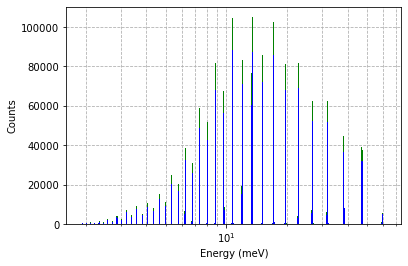

In [12]:
# =============================================================================
#                          ITERATE THROUGH ALL SHOULDERS
# =============================================================================

# Define parameters
shoulder_limits = np.array([[-5, 0], [-10, -5], [-15, -10]])
#shoulder_limits = np.array([[-5, 0]])
mg_hf.set_thick_labels(10)
# Define vectors to store data
mg_r_shoulder_areas_vec = []
mg_nr_shoulder_areas_vec = []
mg_r_peak_centers_vec = []
mg_nr_peak_centers_vec = []
mg_r_shoulder_uncs_vec = []
mg_nr_shoulder_uncs_vec = []
mg_r_peak_areas_vec = []
mg_nr_peak_areas_vec = []
mg_r_peak_uncs_vec = []
mg_nr_peak_uncs_vec = []

# Iterate through limits
for shoulder_limit in shoulder_limits:
    # Get values
    print(shoulder_limit)
    values = get_all_foms(shoulder_limit, energies_r_ls, energies_nr_ls, energies_r_ls_p, energies_nr_ls_p)
    # Store values
    mg_r_shoulder_areas_vec.append(values[0])
    mg_nr_shoulder_areas_vec.append(values[1])
    mg_r_peak_centers_vec.append(values[2])
    mg_nr_peak_centers_vec.append(values[3])
    mg_r_shoulder_uncs_vec.append(values[4])
    mg_nr_shoulder_uncs_vec.append(values[5])
    mg_r_peak_areas_vec.append(values[6])
    mg_nr_peak_areas_vec.append(values[7])
    mg_r_peak_uncs_vec.append(values[8])
    mg_nr_peak_uncs_vec.append(values[9])

/Users/alexanderbackis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/alexanderbackis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/alexanderbackis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/alexanderbackis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


0.3416862043341361 0.08066300296173118
[1.32029745 1.46509956 1.60971446 1.75440055 1.89902213 2.04370161
 2.18829976 2.33293589 2.47752952 2.62223693 2.76677129 2.91138407
 3.05610088 3.20063895 3.34526891 3.4899091  3.63454793 3.77915634
 3.92378396]


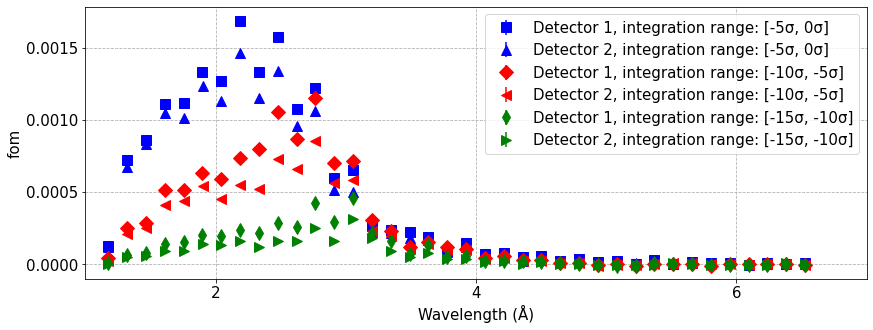

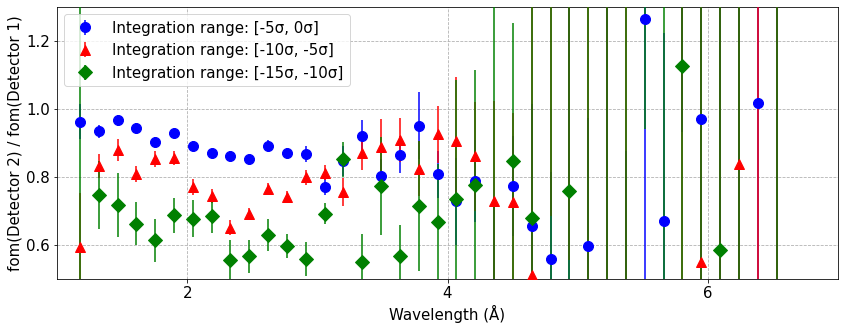

In [19]:
# =============================================================================
#                              PLOT RESULTS
# =============================================================================

def get_mean_and_std(values):
    mean = sum(values)/len(values)
    std = np.sqrt((1/len(values)) * sum(((values - mean) ** 2)))
    return mean, std

mg_hf.set_thick_labels(15)

# Plot areas of shoulders
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
markers = ['o', '^', 'D']
colors = ['blue', 'red', 'green']
markers_fom = ['s', 'D', 'd', '^', '<', '>']
for i, (shoulder_limit, marker, color) in enumerate(zip(shoulder_limits, markers, colors)):
    #plt.subplot(1, len(shoulder_limits), i+1)
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    plt.errorbar(mg_nr_peak_centers_vec[i],
                 mg_nr_shoulder_areas_vec[i]*MONITOR_NORM_NR,#*(1/mg_nr_peak_areas_vec[i]),
                 mg_nr_shoulder_uncs_vec[i]*MONITOR_NORM_NR,#*(1/mg_nr_peak_areas_vec[i]),
                 color=color, marker=markers_fom[i],
                 label='Detector 1, integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]),
                 zorder=5, linestyle='', markersize=10
                )
    plt.errorbar(mg_r_peak_centers_vec[i],
                 mg_r_shoulder_areas_vec[i]*MONITOR_NORM_R,#*(1/mg_r_peak_areas_vec[i]),
                 mg_r_shoulder_uncs_vec[i]*MONITOR_NORM_R,#*(1/mg_nr_peak_areas_vec[i]),
                 color=color, marker=markers_fom[i+3],
                 label='Detector 2, integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]),
                 zorder=5, linestyle='', markersize=10
                )
    plt.legend()
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('fom')
    #plt.title('Integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]))
    plt.xlim(1, 7)
    #plt.ylim(-0.0001, 0.00175)
    #plt.tight_layout()
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    fig.show()
    
    # Save data
    output_path = '../output/foms_vs_lambda.pdf'
    fig.savefig(output_path, bbox_inches='tight')

# Plot FoM of shoulders
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
for i, (shoulder_limit, color, marker) in enumerate(zip(shoulder_limits, colors, markers)):
    # Get uncertainity
    a = mg_r_shoulder_areas_vec[i]*MONITOR_NORM_R
    da = mg_r_shoulder_uncs_vec[i]*MONITOR_NORM_R
    b = mg_nr_shoulder_areas_vec[i]*MONITOR_NORM_NR
    db = mg_nr_shoulder_uncs_vec[i]*MONITOR_NORM_NR
    uncertainity = np.sqrt((da/a) ** 2 + (db/b) ** 2)
    plt.errorbar(mg_r_peak_centers_vec[i],
                 (mg_r_shoulder_areas_vec[i]*MONITOR_NORM_R)/(mg_nr_shoulder_areas_vec[i]*MONITOR_NORM_NR),
                 uncertainity, marker=marker,
                 label='Integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]),
                 zorder=5, linestyle='', color=color, markersize=10)  
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('fom(Detector 2) / fom(Detector 1)')
#plt.title('FoM')
plt.xlim(1, 7)
plt.ylim(0.5, 1.3)
#plt.ylim(-3, 3)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
fig.show()

#summation = sum((mg_r_shoulder_areas_vec[2][0:24]*MONITOR_NORM_R)/(mg_nr_shoulder_areas_vec[2][0:24]*MONITOR_NORM_NR))
#summation = sum((mg_r_shoulder_areas_vec[0][1:24]*MONITOR_NORM_R)/(mg_nr_shoulder_areas_vec[0][1:24]*MONITOR_NORM_NR))
values = (mg_r_shoulder_areas_vec[2][1:20]*MONITOR_NORM_R)/(mg_nr_shoulder_areas_vec[2][1:20]*MONITOR_NORM_NR)

mean, std = get_mean_and_std(values)
print(1- mean, std)
print(mg_r_peak_centers_vec[2][1:20])

# Save data
output_path = '../output/fractional_foms_vs_lambda.pdf'
fig.savefig(output_path, bbox_inches='tight')

/Users/alexanderbackis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/alexanderbackis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/alexanderbackis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/alexanderbackis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


[-5$\sigma$, 0$\sigma$]
0.06271248190275891 0.05667135386851993
[-10$\sigma$, -5$\sigma$]
0.16682146317965008 0.08298132452199351
[-15$\sigma$, -10$\sigma$]
0.31384722171872803 0.08288713284859762
[1.32029745 1.46509956 1.60971446 1.75440055 1.89902213 2.04370161
 2.18829976 2.33293589 2.47752952 2.62223693 2.76677129 2.91138407
 3.05610088 3.20063895 3.34526891 3.4899091  3.63454793 3.77915634
 3.92378396]


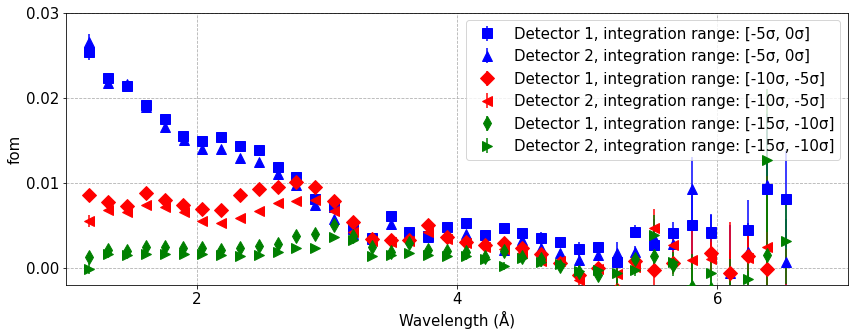

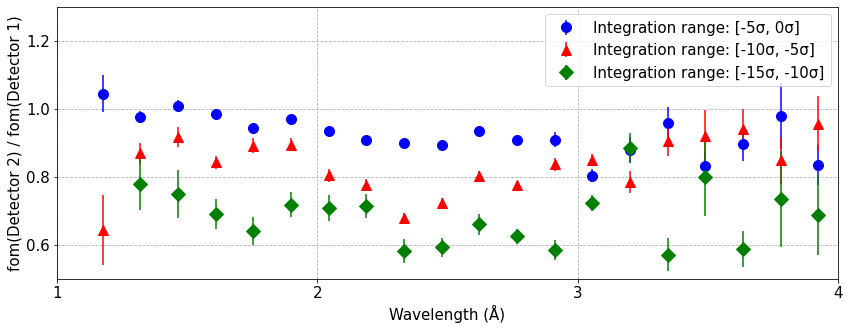

In [27]:
# =============================================================================
#                           PLOT RESULTS - VERSION 3
# =============================================================================

def get_mean_and_std(values):
    mean = sum(values)/len(values)
    std = np.sqrt((1/len(values)) * sum(((values - mean) ** 2)))
    return mean, std

mg_hf.set_thick_labels(15)
#print(mg_nr_peak_areas_vec)
#print(mg_r_peak_areas_vec)
# Plot areas of shoulders
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)

markers = ['o', '^', 'D']
markers_fom = ['s', 'D', 'd', '^', '<', '>']
colors = ['blue', 'red', 'green']
for i, (shoulder_limit, marker, color) in enumerate(zip(shoulder_limits, markers, colors)):
    #plt.subplot(1, len(shoulder_limits), i+1)
    plt.grid(True, which='major', linestyle='--', zorder=0)
    plt.grid(True, which='minor', linestyle='--', zorder=0)
    
    # Get uncertainity
    a = mg_r_shoulder_areas_vec[i]
    da = mg_r_shoulder_uncs_vec[i]
    b = mg_nr_shoulder_areas_vec[i]
    db = mg_nr_shoulder_uncs_vec[i]
    c = mg_r_peak_areas_vec[i]
    dc = mg_r_peak_uncs_vec[i]
    d = mg_nr_peak_areas_vec[i]
    dd = mg_nr_peak_uncs_vec[i]
    
    values_r = a/c
    values_nr = b/d
    uncertainty_r = np.sqrt((da/a) ** 2 + (dc/c) ** 2)
    uncertainty_nr = np.sqrt((db/b) ** 2 + (dd/d) ** 2)


    plt.errorbar(mg_nr_peak_centers_vec[i],
                 values_nr,
                 uncertainty_nr*values_nr,
                 color=color, marker=markers_fom[i],
                 label='Detector 1, integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]),
                 zorder=5, linestyle='', markersize=10
                )
    plt.errorbar(mg_r_peak_centers_vec[i],
                 values_r,
                 uncertainty_r*values_r,
                 color=color, marker=markers_fom[i+3],
                 label='Detector 2, integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]),
                 zorder=5, linestyle='', markersize=10
                )
    plt.legend()
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('fom')
    #plt.title('Integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]))
    plt.xlim(1, 7)
    plt.ylim(-0.002, 0.03)
    #plt.tight_layout()
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    fig.show()
    
    # Save data
    output_path = '../output/foms_vs_lambda.pdf'
    fig.savefig(output_path, bbox_inches='tight')

# Plot FoM of shoulders
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
for i, (shoulder_limit, color, marker) in enumerate(zip(shoulder_limits, colors, markers)):
    # Get uncertainity
    a = mg_r_shoulder_areas_vec[i]
    da = mg_r_shoulder_uncs_vec[i]
    b = mg_nr_shoulder_areas_vec[i]
    db = mg_nr_shoulder_uncs_vec[i]
    c = mg_r_peak_areas_vec[i]
    dc = mg_r_peak_uncs_vec[i]
    d = mg_nr_peak_areas_vec[i]
    dd = mg_nr_peak_uncs_vec[i]
    uncertainity = np.sqrt((da/a) ** 2 + (db/b) ** 2 + (dc/c) ** 2 + (dd/d) ** 2)
    values = (mg_r_shoulder_areas_vec[i]*(1/mg_r_peak_areas_vec[i]))/(mg_nr_shoulder_areas_vec[i]*(1/mg_nr_peak_areas_vec[i]))
    #print(values)
    plt.errorbar(mg_r_peak_centers_vec[i],
                 values,
                 uncertainity*values, marker=marker,
                 label='Integration range: [%dσ, %dσ]' % (shoulder_limit[0], shoulder_limit[1]),
                 zorder=5, linestyle='', color=color, markersize=10)  
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('fom(Detector 2) / fom(Detector 1)')
#plt.title('FoM')
plt.xlim(1, 4) # plt.xlim(1, 7)
plt.ylim(0.5, 1.3)
#plt.ylim(-3, 3)
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
fig.show()

#summation = sum((mg_r_shoulder_areas_vec[2][0:24]*MONITOR_NORM_R)/(mg_nr_shoulder_areas_vec[2][0:24]*MONITOR_NORM_NR))
#summation = sum((mg_r_shoulder_areas_vec[0][1:24]*MONITOR_NORM_R)/(mg_nr_shoulder_areas_vec[0][1:24]*MONITOR_NORM_NR))
values_1 = (mg_r_shoulder_areas_vec[0][0:14]*(1/mg_r_peak_areas_vec[0][0:14]))/(mg_nr_shoulder_areas_vec[0][0:14]*(1/mg_nr_peak_areas_vec[0][0:14]))
values_2 = (mg_r_shoulder_areas_vec[1][0:20]*(1/mg_r_peak_areas_vec[1][0:20]))/(mg_nr_shoulder_areas_vec[1][0:20]*(1/mg_nr_peak_areas_vec[1][0:20]))
values_3 = (mg_r_shoulder_areas_vec[2][1:20]*(1/mg_r_peak_areas_vec[2][1:20]))/(mg_nr_shoulder_areas_vec[2][1:20]*(1/mg_nr_peak_areas_vec[2][1:20]))

mean, std = get_mean_and_std(values_1)
print('[-5$\sigma$, 0$\sigma$]')
print(1-mean, std)
mean, std = get_mean_and_std(values_2)
print('[-10$\sigma$, -5$\sigma$]')
print(1-mean, std)
mean, std = get_mean_and_std(values_3)
print('[-15$\sigma$, -10$\sigma$]')
print(1-mean, std)

print(mg_r_peak_centers_vec[0][1:20])

# Save data
output_path = '../output/fractional_foms_vs_lambda.pdf'
fig.savefig(output_path, bbox_inches='tight')
#print(MONITOR_NORM_R/MONITOR_NORM_NR)
#print((1/578715.8)/(1/478870))

In [ ]:
mg_hf.A_to_meV(5)

In [ ]:
# Normalize shoulder areas with beam monitor data
mg_r_shoulder_foms = mg_r_shoulder_areas*MONITOR_NORM_R
mg_nr_shoulder_foms = mg_nr_shoulder_areas*MONITOR_NORM_NR

# Plot FoM
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.errorbar(mg_r_peak_centers_ls, mg_r_shoulder_foms, mg_r_shoulder_unc*MONITOR_NORM_R,
             color='green', marker='.', label='Multi-Grid detector:R', zorder=5)
plt.errorbar(mg_nr_peak_centers_ls, mg_nr_shoulder_foms, mg_nr_shoulder_unc*MONITOR_NORM_NR,
             color='blue', marker='.', label='Multi-Grid detector:NR', zorder=5)
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('Shoulder area (Normalized counts)')
plt.title('FoM')
plt.xlim(0, 7)
fig.show()

# Plot FoM, fraction MG_R/MG_NR
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.errorbar(mg_r_peak_centers_ls, mg_r_shoulder_foms/mg_nr_shoulder_foms,
             color='black', marker='.', label='Fraction: R/NR', zorder=5)
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('Fraction R/NR (counts)')
plt.title('FoM')
plt.xlim(0, 7)
plt.ylim(0, 1)
fig.show()

##### 4.4 Time- and energy resolution

In [ ]:
%matplotlib inline
print(mg_hf.meV_to_A(4.3))
mg_hf.set_thick_labels(11)
# Plot data
#fig = mg_advanced_plot.layers_tof(mg_r, 'Radial coating')
#fig.show()

number_bins = 300
#fig = mg_advanced_plot.layers_tof(mg_nr, 'No radial coated', number_bins=number_bins)
#he3_plot.tof_histogram(he3, number_bins, 'Helium-3 tube', color='red', interval=[19700, 20050])
#plt.locator_params(axis='x', nbins=5)
#plt.ylabel('Normalized counts')
#plt.xlabel('tof (µs)')
#plt.title('')
#plt.legend()
#fig.show()
# Save data
#output_path = '../output/tof_double_peak.pdf'
#fig.savefig(output_path, bbox_inches='tight')

# Calculate energy distribution
#us_to_tdc = 1 / (62.5e-9 * 1e6)
energies_nr = mg_energy.get_energies(mg_nr, DIST_OFFSET_NR)
energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3)

#energies_nr = mg_energy.get_energies(mg_nr, DIST_OFFSET_NR)
#energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3)

# Declare parameters
number_bins = 100
start = mg_hf.meV_to_A(2.434)     # 0.8 # Å    # 2.434 to 2.42 meV, when looking at peak which we get double peak from
stop = mg_hf.meV_to_A(2.42)       #  10 # Å    # 10.8 to 10.6 when looking at the single peak

# Plot
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(6)
__, __ = mg_advanced_plot.energy_plot(energies_nr, number_bins, 'Multi-Grid detector',
                                      useMaxNorm=True, start=start, stop=stop,
                                      #scaling=MONITOR_NORM_NR,
                                      color='blue')
__, __ = he3_plot.energy_plot(energies_he3, number_bins, 'Helium-3 tube', 
                              useMaxNorm=True, start=start, stop=stop,
                              #scaling=MONITOR_NORM_HE3,
                              color='red')
plt.xscale('linear')
plt.yscale('linear')
plt.title('')
plt.ylabel('Normalized counts')
plt.legend(title='Detector', loc=1)
plt.locator_params(axis='x', nbins=5)
fig.show()

# Save data
output_path = '../output/energy_double_peak.pdf'
fig.savefig(output_path, bbox_inches='tight')

In [ ]:
(3e-3)/(5e-3)

###### 4.4.2 FWHM investigation

In [ ]:
# Second version of he-3 isolines
mean_abs = np.loadtxt('../tables/lambda_vs_mean_depth.txt', delimiter=",", unpack=True)
upper_abs = np.loadtxt('../tables/lambda_vs_upper_depth.txt', delimiter=",", unpack=True)
lower_abs = np.loadtxt('../tables/lambda_vs_lower_depth.txt', delimiter=",", unpack=True)

def get_he3_iso_line():
    # Declare parameters
    distances = 28.24 + 0.01*mean_abs[1]  # m
    lower_deltas = 0.01 * (mean_abs[1] - lower_abs[1])
    upper_deltas = 0.01 * (upper_abs[1] - mean_abs[1])
    wavelengths = np.arange(1, 7.05, 0.05)
    delta_e = []
    e = []
    for distance, lower_delta, upper_delta, wavelength in zip(distances, lower_deltas, upper_deltas, wavelengths):
        tof = (distance/(3956/wavelength))
        v_1 = (distance - lower_delta) / tof
        v_2 = (distance + upper_delta) / tof
        v = distance/tof
        E = (v / 437) ** 2
        E_1 = (v_1 / 437) ** 2
        E_2 = (v_2 / 437) ** 2
        delta_e.append((E_2 - E_1))
        e.append(E_1)
    plt.plot(wavelengths, delta_e, color='red', linestyle='dashed',
             label='Conversion uncertainty, helium-3 tube (0.30 to 1.81 cm)')
    

In [ ]:
def get_iso_line():
    # Declare parameters
    distance = 28.5  # m
    delta_distance = 0.0095  # m
    wavelengths = np.arange(1, 7, 0.1)
    delta_e = []
    e = []
    for wavelength in wavelengths:
        tof = distance/(3956/wavelength)
        v_1 = (distance - delta_distance/2) / tof
        v_2 = (distance + delta_distance/2) / tof
        v = distance/tof
        E = (v / 437) ** 2
        E_1 = (v_1 / 437) ** 2
        E_2 = (v_2 / 437) ** 2
        delta_e.append((E_2 - E_1))
        e.append(E_1)
    plt.plot(wavelengths, delta_e, color='blue', linestyle='solid',
             label='Conversion uncertainty, Multi-Grid detector (0.95 cm)')
    
    
def get_he3_iso_line():
    # Declare parameters
    distance = 28.24  # m
    delta_distances = 0.01 * np.array([1.80594, 1.7576800000000001, 1.7068800000000002, 1.6611600000000002, 1.6129, 1.56718, 1.52146, 1.47828, 1.4351, 1.39446, 1.35382, 1.31572, 1.2801600000000002, 1.2446000000000002, 1.21158, 1.17856, 1.14808, 1.1176000000000001, 1.08966, 1.06426, 1.0388600000000001, 1.01346, 0.98806, 0.96774, 0.94488, 0.92456, 0.90424, 0.88646, 0.86614, 0.84836, 0.8331200000000001, 0.8153400000000001, 0.8001, 0.78486, 0.7721600000000001, 0.75692, 0.74422, 0.7315200000000001, 0.71882, 0.7061200000000001, 0.69342, 0.6832600000000001, 0.67056, 0.6604, 0.65024, 0.6400800000000001, 0.62992, 0.6223000000000001, 0.61214, 0.6019800000000001, 0.59436, 0.58674, 0.57658, 0.56896, 0.5613400000000001, 0.55372, 0.5461, 0.5410200000000001, 0.5334, 0.52578, 0.5207, 0.51308, 0.508, 0.50038, 0.4953, 0.49022000000000004, 0.48260000000000003, 0.47752000000000006, 0.47244, 0.46736000000000005, 0.46228, 0.45720000000000005, 0.45212, 0.44704000000000005, 0.44196, 0.43688000000000005, 0.4318, 0.42926000000000003, 0.42418, 0.41910000000000003, 0.41402, 0.41148, 0.40640000000000004, 0.40386000000000005, 0.39878, 0.39624000000000004, 0.39116, 0.38862, 0.38354000000000005, 0.381, 0.37846, 0.37338000000000005, 0.37084, 0.3683, 0.36322000000000004, 0.36068, 0.35814, 0.3556, 0.35052, 0.34798, 0.34544, 0.34290000000000004, 0.34036, 0.33782, 0.33528, 0.33274000000000004, 0.3302, 0.32766, 0.32512, 0.32258000000000003, 0.32004000000000005, 0.3175, 0.31496, 0.31242000000000003, 0.30988000000000004, 0.30734, 0.3048, 0.30226000000000003, 0.29972000000000004, 0.29718, 0.29718])
   # delta_distances = 0.01 * np.array([2.06502, 2.02438, 1.98374, 1.94056, 1.89484, 1.85166, 1.80848, 1.76276, 1.71958,
 #1.67386, 1.63068, 1.59258, 1.55194, 1.5113,  1.47066, 1.4351,  1.397,   1.36398,
 #1.33096, 1.29794, 1.27,    1.23952, 1.21158, 1.18364, 1.15824, 1.13284, 1.10744,
 #1.08458, 1.06172, 1.0414,  1.02108, 1.00076, 0.98044, 0.96266, 0.94488, 0.9271,
 #0.9144,  0.89662, 0.88138, 0.86614, 0.85344, 0.8382,  0.8255,  0.8128,  0.8001,
 #0.7874,  0.7747,  0.762,   0.75184, 0.74168, 0.72898, 0.71882, 0.70866, 0.6985,
 #0.69088, 0.68072, 0.6731,  0.66294, 0.65532, 0.64516, 0.63754, 0.62992, 0.6223,
 #0.61468, 0.60706, 0.59944, 0.59436, 0.58674, 0.57912, 0.57404, 0.56642, 0.56134,
 #0.55372, 0.54864, 0.5461,  0.53848, 0.5334,  0.52832, 0.52324, 0.51816, 0.51308,
 #0.508,   0.50292, 0.49784, 0.49276, 0.48768, 0.4826,  0.47752, 0.47498, 0.4699,
 #0.46482, 0.45974, 0.4572,  0.45212, 0.44958, 0.4445,  0.44196, 0.43688, 0.43434,
 #0.42926, 0.42672, 0.42164, 0.4191,  0.41656, 0.41148, 0.40894, 0.4064,  0.40132,
 #0.39878, 0.39624, 0.3937,  0.39116, 0.38608, 0.38354, 0.381,   0.37846, 0.37592,
 #0.37338, 0.37084, 0.3683,  0.36576])
    wavelengths = np.arange(1, 7.05, 0.05)
    delta_e = []
    e = []
    for delta_distance, wavelength in zip(delta_distances, wavelengths):
        tof = (distance/(3956/wavelength))
        v_1 = (distance - delta_distance/2) / tof
        v_2 = (distance + delta_distance/2) / tof
        v = distance/tof
        E = (v / 437) ** 2
        E_1 = (v_1 / 437) ** 2
        E_2 = (v_2 / 437) ** 2
        delta_e.append((E_2 - E_1))
        e.append(E_1)
    plt.plot(wavelengths, delta_e, color='red', linestyle='dashed',
             label='Conversion uncertainty, helium-3 tube (0.30 to 1.81 cm)')
    

In [ ]:
# Declare parameters
mg_hf.set_thick_labels(12)
mg_values = []
mg_values_unc_upper = []
mg_values_unc_lower = []
mg_k_values = []
he3_k_values = []
he3_values = []
he3_values_unc = []
peak_energies = []

print(PEAKS)
# Iterate through peaks
for peak in PEAKS[3:30]:
    figs, mg_value, he3_value, mg_k_value, he3_k_value, unc_mg, unc_he3 = mg_advanced_plot.investigate_layers_FWHM(peak, mg_nr, he3,
                                                                                                      DIST_OFFSET_NR,
                                                                                                      DIST_OFFSET_HE3)
    # Store values
    mg_values.append(mg_value)
    mg_values_unc_lower.append(unc_mg[0])
    mg_values_unc_upper.append(unc_mg[1])
    he3_values.append(he3_value)
    he3_values_unc.append(unc_he3)
    peak_energies.append(peak)
    mg_k_values.append(mg_k_value)
    he3_k_values.append(he3_k_value)
    
    # Save plot
    output_path_1 = '../output/MG_fitted_peak_at_%d_A.pdf' % ((peak*100)//1)
    output_path_2 = '../output/inter_fitted_peak_at_%d_A.pdf' % ((peak*100)//1)
    #if peak == 2.044:
    #    plt.plot([0.15, 1], [0.019, 0.019*(1/0.15)], color='black')
    fig_1, fig_2 = figs
    fig_1.savefig(output_path_1, bbox_inches='tight')
    fig_2.savefig(output_path_2, bbox_inches='tight')
    plt.close()

In [ ]:
%matplotlib inline
mg_hf.set_thick_labels(10)

# Plot mg and he3 FWHMs, interpolated to He-3 position
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(6)
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
mg_values = np.array(mg_values)
mg_values_unc_lower = np.array(mg_values_unc_lower)
mg_values_unc_upper = np.array(mg_values_unc_upper)
plt.errorbar(peak_energies, mg_values, yerr=[mg_values - mg_values_unc_lower,
                                             mg_values_unc_upper - mg_values],
             color='blue', label='FWHM, Multi-Grid detector (interpolated)',
             marker='.', zorder=5, linestyle='')
plt.errorbar(peak_energies, he3_values, yerr=he3_values_unc, color='red', label='FWHM, Helium-3 tube',
         marker='s', zorder=5, linestyle='', markersize=3)
get_iso_line()
get_he3_iso_line()
#plt.yscale('log')
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('$\Delta$E (meV)')
plt.title('Linear')
plt.xlim(1.25, 4.6)

#fig.show()
#fig = plt.figure()
#plt.plot(peak_energies, np.array(mg_values)/np.array(he3_values), marker='.', color='black')
#fig.show()

# Save data
output_path = '../output/fwhm_interpolated_vs_lambda_lin.pdf'
fig.savefig(output_path, bbox_inches='tight')


# Plot mg and he3 FWHMs, interpolated to He-3 position
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(6)
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
mg_values = np.array(mg_values)
mg_values_unc_lower = np.array(mg_values_unc_lower)
mg_values_unc_upper = np.array(mg_values_unc_upper)
plt.errorbar(peak_energies, mg_values, yerr=[mg_values - mg_values_unc_lower,
                                             mg_values_unc_upper - mg_values],
             color='blue', label='FHWM, Multi-Grid detector (interpolated)',
             marker='.', zorder=5, linestyle='')
plt.errorbar(peak_energies, he3_values, yerr=he3_values_unc, color='red', label='FWHM, Helium-3 tube',
         marker='s', zorder=5, linestyle='', markersize=3)
get_iso_line()
get_he3_iso_line()
#plt.yscale('log')
plt.legend()
plt.yscale('log')
plt.xlabel('Wavelength (Å)')
plt.ylabel('$\Delta$E (meV)')
plt.title('Logarithmic')
plt.xlim(1.25, 4.6)
print(peak_energies)
#fig.show()
#fig = plt.figure()
#plt.plot(peak_energies, np.array(mg_values)/np.array(he3_values), marker='.', color='black')
#fig.show()

# Save data
output_path = '../output/fwhm_interpolated_vs_lambda_log.pdf'
fig.savefig(output_path, bbox_inches='tight')


# Plot k values
#fig = plt.figure()
#plt.plot(peak_energies, mg_k_values, color='blue', label='MG k-values')
#plt.plot(peak_energies, he3_k_values, color='red', label='He-3 k-values')
#plt.grid(True, which='major', linestyle='--', zorder=0)
#plt.grid(True, which='minor', linestyle='--', zorder=0)
#plt.legend()
#fig.show()

In [ ]:
# Plot mg and he3 FWHMs
fig = plt.figure()
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.errorbar(mg_peak_centers, mg_peak_widths, mg_width_unc, color='blue',
             label='Multi-Grid detector: FWHM', marker='.', zorder=5)
plt.errorbar(he3_peak_centers, he3_peak_width, he3_width_unc, color='red',
             label='Helium-3 tube: FWHM', marker='.', zorder=5)
plt.yscale('log')
plt.legend()
plt.xlabel('Wavelength (Å)')
plt.ylabel('FWHM')
fig.show()

# Plot fractions
fig = plt.figure()
plt.plot(peak_energies, np.array(mg_values)/np.array(he3_values),
         marker='.', color='black', zorder=5, label='Interpolated fraction')
plt.plot(mg_peak_centers, mg_peak_widths/he3_peak_width,
         marker='.', color='black', linestyle='dashed', zorder=5, label='Fraction')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.legend()
fig.show()

In [ ]:
# FWHM investigation of time-of-flight


##### 4.5 Parasitic peaks

In [ ]:
# Multi-Grid @ 5.1 Å
start = 35462  # us
end = 36493 # us
peak = 36182 # us
duration_mg = end - start
peak_loc_mg = peak - start
print('--------------------')
print('Multi-Grid')
print('Duration: %d us' % duration_mg)
print('Peak location: %d us' % peak_loc_mg)
print('Relative peak location: %.2f' % (peak_loc_mg/duration_mg))
print('--------------------')

# Helium-3 @ 5.1 Å
start = 35231 # us
end = 36260 # us
peak = 36048 # us
duration_he3 = end - start
peak_loc_he3 = peak - start
print('--------------------')
print('Helium-3')
print('Duration: %d us' % duration_he3)
print('Peak location: %d us' % peak_loc_he3)
print('Relative peak location: %.2f' % (peak_loc_he3/duration_he3))
print('--------------------')

# Additional analysis for paper revision

In [ ]:
# He-3 time-of-flight, peak relative locations
intervals = [[23874.2, 25938.7], [34200.5, 36265], [44512, 46572.8]]
peaks_vec = [[23874.2, 24394, 24736.9, 24821.7, 24906.5, 25437.3, 25761.8, 25857.6, 25938.7],
             [34200.5, 34724, 35022.6, 35133.2, 35232.7, 35756.2, 36051.2, 36169.1, 36265],
             [44512, 45024.4, 45367.3, 45463.1, 45540.6, 46067.7, 46410.6, 46488, 46572.8]]
for interval, peaks in zip(intervals, peaks_vec):
    start, end = interval
    duration = end - start
    print('--------------------')
    for i, peak in enumerate(peaks):
        peak_location = (peak - start)/duration
        print('Peak %d: %.2f' % (i, peak_location))
    print('--------------------')

In [ ]:
%matplotlib
# Calculate energy distribution
energies_r = mg_energy.get_energies(mg_r, DIST_OFFSET_R)
energies_nr = mg_energy.get_energies(mg_nr, DIST_OFFSET_NR)
energies_r_blocked = mg_energy.get_energies(mg_r_blocked, DIST_OFFSET_R)
energies_nr_blocked = mg_energy.get_energies(mg_nr_blocked, DIST_OFFSET_NR)
energies_he3 = he3_energy.get_energies(he3, DIST_OFFSET_HE3)

# Declare parameters
number_bins = 50000
start = 0.5
stop = 10

# Plot
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
__, __ = mg_advanced_plot.wavelength_plot(energies_r, number_bins, 'Radial coating',
                                          useMaxNorm=False, start=start, stop=stop, scaling=)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr, number_bins, 'No radial coating',
                                          useMaxNorm=False, start=start, stop=stop)
__, __ = mg_advanced_plot.wavelength_plot(energies_r_blocked, number_bins, 'Radial coating (blocked)',
                                          useMaxNorm=False, start=start, stop=stop)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr_blocked, number_bins, 'No radial coating (blocked)',
                                          useMaxNorm=False, start=start, stop=stop)
__, __ = he3_plot.wavelength_plot(energies_he3, number_bins, 'Helium-3 tube',
                                  useMaxNorm=True, start=start, stop=stop)
plt.legend()
fig.show()
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
__, __ = mg_advanced_plot.wavelength_plot(energies_r, number_bins, 'Radial coating',
                                          useMaxNorm=False, start=start, stop=stop)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr, number_bins, 'No radial coating', 
                                          useMaxNorm=False, start=start, stop=stop)
__, __ = mg_advanced_plot.wavelength_plot(energies_r_blocked, number_bins, 'Radial coating (blocked)',
                                          useMaxNorm=False, start=start, stop=stop)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr_blocked, number_bins, 'No radial coating (blocked)',
                                          useMaxNorm=False, start=start, stop=stop)
__, __ = he3_plot.wavelength_plot(energies_he3, number_bins, 'Helium-3 tube',
                                  useMaxNorm=False, start=start, stop=stop)
plt.legend()
plt.yscale('log')
fig.show()

# Plot for paper: Multi-Grid (non-coated) vs Helium-3
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(14)
__, __ = mg_advanced_plot.wavelength_plot(energies_nr, number_bins, 'Multi-Grid detector',
                                          useMaxNorm=False, start=start, stop=stop, color='blue')
__, __ = he3_plot.wavelength_plot(energies_he3, number_bins, 'Helium-3 tube',
                                  useMaxNorm=False, start=start, stop=stop, color='red')
plt.legend()
fig.show()

### SEQUOIA ANALYSIS

In [ ]:
def get_mean_and_std(values):
    mean = sum(values)/len(values)
    std = np.sqrt((1/len(values)) * sum(((values - mean) ** 2)))
    return mean, std

ESS_CLB = np.array([0.004, 0.005, 0.004, 0.006, 0.006, 0.006, 0.008,
                    0.0065, 0.0065, 0.0052, 0.0062, 0.007, 0.007, 0.0065])
ESS_PA = np.array([0.0075, 0.010, 0.009, 0.0078, 0.009, 0.0105,
                   0.013, 0.010, 0.0083, 0.009, 0.010, 0.0095, 0.011, 0.0115])
wavelengths = mg_hf.meV_to_A(np.array([8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 50, 60]))
fractions = ESS_CLB/ESS_PA
mean, std = get_mean_and_std(fractions)
fig = plt.figure()
plt.plot(wavelengths, (1- fractions)*100, '.', color='black')
plt.grid(True, which='major', linestyle='--', zorder=0)
plt.grid(True, which='minor', linestyle='--', zorder=0)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Improvement (%)')
plt.title('SEQUOIA data')
# Save data
output_path = '../output/seq_improvement.pdf'
fig.savefig(output_path, bbox_inches='tight')
print(1-mean, std)

### References